In [6]:
import os
import pandas as pd
from custom_finta import TA
# import ipdb
import datetime
import collections
import numpy as np
import math
import copy
import random
from datetime import timedelta
import warnings
import copy
import sys
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from multiprocessing import Process, Manager
EPSILON = sys.float_info.epsilon
config = collections.OrderedDict()

In [7]:
BROKERAGE_EST =  5

def DrawDown_fast(ReturnList):
	try:
		sumRet = np.cumsum(ReturnList)
		i = np.argmax(np.maximum.accumulate(sumRet) - sumRet) # end of the period
		j = np.argmax(sumRet[:i]) # start of period
		maxD = sumRet[i] - sumRet[j]
		return (maxD, [i, j])
	except:
		return (100, [0, 0])

def max_dd(ser):
	max2here = ser.cummax()
	dd2here = ser - max2here
	return dd2here.min()/ser[-1]


def long_short_analysis(trade_df):
	def get_stats(trade_df):
		key_list = [x for x in set(trade_df['key'].tolist())]
		master_trade_stats_df  = pd.DataFrame()
		master_day_stats_df  = pd.DataFrame()
		for key in key_list:
			df = trade_df[trade_df['key'] == key]
			for qty in [1, -1]:
				_df = df[df['qty'] == qty]
				if qty == 1:
					prefix = 'long_trades'
				else:
					prefix = 'short_trades'
				(trade_stat_df, day_stat_df) = output_stats(_df, total_days, prefix = prefix)
				master_trade_stats_df =  pd.concat([master_trade_stats_df, trade_stat_df], axis=1)
				master_day_stats_df =  pd.concat([master_day_stats_df, day_stat_df], axis=1)
			(trade_stat_df, day_stat_df) = output_stats(df, total_days, prefix = 'all_trades')
			master_trade_stats_df =  pd.concat([master_trade_stats_df, trade_stat_df], axis=1)
			master_day_stats_df =  pd.concat([master_day_stats_df, day_stat_df], axis=1)
		return (master_trade_stats_df, master_day_stats_df)
	
	trade_df['entry_ts'] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df['exit_ts'] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')

	(day_stat_df, strat_daywise_pnl)  = get_daywise_stats(key, trade_df, total_days, return_daywise_pnl = True)

	(master_trade_stats_df, master_day_stats_df) = get_stats(trade_df)
	trade_df['key'] = trade_df['key'].apply(lambda x: "all_" + "_".join(x.split("_")[1:]))
	(trade_stat_df, day_stat_df) = get_stats(trade_df)
	master_trade_stats_df =  pd.concat([master_trade_stats_df, trade_stat_df], axis=1)
	master_day_stats_df =  pd.concat([master_day_stats_df, day_stat_df], axis=1)
	master_trade_stats_df.to_csv("long_short_trade_stats.csv")
	master_day_stats_df.to_csv("long_short_day_stats.csv")

In [8]:
def periodwise_performance_analysis(trade_df, frequency = 'yearly'):
	trade_df['entry_ts'] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df['exit_ts'] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	master_trade_stats_df  = pd.DataFrame()
	master_day_stats_df  = pd.DataFrame()
	if frequency =='yearly':
		trade_df['freq'] = trade_df['entry_ts'].dt.year
		year_list =  set(trade_df['freq'].tolist())
		for year in year_list:
			year_trade_df = trade_df[trade_df['freq'] == year]
			year_total_days =  len([x for x in DATE_LIST if x.year == year])
			year_trade_df['key'] = year_trade_df['key'].apply(lambda x: str(year) + "_" + "_".join(x.split("_")[1:]))
			(master_trade_stats_df, master_day_stats_df) = output_stats(year_trade_df, year_total_days, master_trade_stats_df, \
																		 master_day_stats_df, prefix= 'year:' + str(year))
	elif frequency == 'monthly':
		trade_df['freq'] = trade_df['entry_ts'].apply(lambda x: str(x.year) + "-" + '%02d' % x.month)
		freq_list =  set(trade_df['freq'].tolist())
		for freq in freq_list:
			freq_trade_df = trade_df[trade_df['freq'] == freq]
			freq_total_days =  len([x for x in DATE_LIST if str(x.year) + "-" + '%02d' % x.month == freq])

			freq_trade_df['key'] = freq_trade_df['key'].apply(lambda x: str(freq) + "_" + "_".join(x.split("_")[1:]))
			(master_trade_stats_df, master_day_stats_df) = output_stats(freq_trade_df, freq_total_days, master_trade_stats_df, \
																		 master_day_stats_df, prefix = freq)
	master_trade_stats_df.to_csv(str(frequency) + "_performance_analysis_trade_stats.csv")
	master_day_stats_df.to_csv(str(frequency) + "_performance_analysis_day_stats.csv")

In [9]:
def volatility_analysis(trade_df):
	trade_df['entry_ts'] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df['exit_ts'] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	symbol_list = [x for x in set(trade_df['symbol'].tolist())]
	day_trade_df = get_daywise_pnl(trade_df, symbol_list = symbol_list)
	for lookback_days in [10, 5]:
		std_df = day_trade_df.rolling(lookback_days).std()
		num_buckets = 4
		new_df = pd.DataFrame()
		new_df.loc['pnl_per_day_bps', 'all'] = round(day_trade_df[lookback_days:].mean(), 1)
		new_df.loc['std_bps', 'all'] = round(day_trade_df[lookback_days:].std(), 1)
		new_df.loc['sharpe', 'all'] = round(new_df.loc['pnl_per_day_bps', 'all']/new_df.loc['std_bps', 'all'], 3)
		std_df = std_df.shift(1)
		for bucket_num in range(num_buckets):
			left_quantile = round(bucket_num*1.0/num_buckets, 2)
			right_quantile = round((bucket_num + 1)*1.0/num_buckets, 2)
			_std_df =  std_df[(std_df <= std_df.quantile(right_quantile)) & (std_df > std_df.quantile(left_quantile))]
			_day_trade_df = day_trade_df[(std_df <= std_df.quantile(right_quantile)) & (std_df > std_df.quantile(left_quantile))]
			avg_pnl_per_day = _day_trade_df.mean()
			std = _day_trade_df.std()
			new_df.loc['avg_std', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(_std_df.mean(), 2)
			new_df.loc['pnl_per_day_bps', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(avg_pnl_per_day, 1)
			new_df.loc['std_bps', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(std, 1)
			new_df.loc['sharpe', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(avg_pnl_per_day/std, 3)
			t_value, p_value = stats.ttest_1samp(_day_trade_df.tolist(), day_trade_df.mean())
			new_df.loc['tval',  str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(t_value, 2)		

		print (lookback_days)
		print (new_df.T)
		print ("\n\n")


In [10]:
def profit_mometum_analysis(trade_df):
	trade_df['entry_ts'] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df['exit_ts'] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	symbol_list = [x for x in set(trade_df['symbol'].tolist())]
	ls = [[s] for s in symbol_list]
	ls.insert(0, symbol_list)
	for symbol_list in ls:
		print (symbol_list)
		_trade_df = trade_df[trade_df['symbol'].isin(symbol_list)]
		day_trade_df = get_daywise_pnl(_trade_df, symbol_list = symbol_list)
		for lookback_days in [3, 1]:
			rolling_mean_pnl_df = day_trade_df.rolling(lookback_days).mean()
			rolling_mean_pnl_df = rolling_mean_pnl_df.shift(1)
			num_buckets = 4
			new_df = pd.DataFrame()
			new_df.loc['pnl_per_day_bps', 'all'] = round(day_trade_df[lookback_days:].mean(), 1)
			new_df.loc['std_bps', 'all'] = round(day_trade_df[lookback_days:].std(), 1)
			new_df.loc['sharpe', 'all'] = round(new_df.loc['pnl_per_day_bps', 'all']/new_df.loc['std_bps', 'all'], 3)
			for bucket_num in range(num_buckets):
				left_quantile = round(bucket_num*1.0/num_buckets, 2)
				right_quantile = round((bucket_num + 1)*1.0/num_buckets, 2)
				_rolling_mean_pnl_df =  rolling_mean_pnl_df[(rolling_mean_pnl_df <= rolling_mean_pnl_df.quantile(right_quantile)) & (rolling_mean_pnl_df > rolling_mean_pnl_df.quantile(left_quantile))]
				_day_trade_df = day_trade_df[(rolling_mean_pnl_df <= rolling_mean_pnl_df.quantile(right_quantile)) & (rolling_mean_pnl_df > rolling_mean_pnl_df.quantile(left_quantile))]
				avg_pnl_per_day = _day_trade_df.mean()
				std = _day_trade_df.std()
				new_df.loc['avg_pnl_for_past', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(_rolling_mean_pnl_df.mean(), 2)
				new_df.loc['pnl_per_day_bps', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(avg_pnl_per_day, 1)
				new_df.loc['std_bps', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(std, 1)
				new_df.loc['sharpe', str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(avg_pnl_per_day/std, 3)
				t_value, p_value = stats.ttest_1samp(_day_trade_df.tolist(), day_trade_df.mean())
				new_df.loc['tval',  str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(t_value, 2)		

			print (lookback_days)
			print (new_df.T)
			print ("\n\n")	

In [11]:
def market_regime_analysis(trade_df):
	master_trade_stats_df  = pd.DataFrame()
	master_day_stats_df  = pd.DataFrame()
	month_move_df = pd.read_csv("monthly_move.csv")
	negative_months = month_move_df[month_move_df['pnl_bps']<-30]['date'].tolist()
	positive_months = month_move_df[month_move_df['pnl_bps']>30]['date'].tolist()
	neutral_months = month_move_df[(month_move_df['pnl_bps']<30) & (month_move_df['pnl_bps']>-30)]['date'].tolist()

	trade_df["entry_ts"] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df["exit_ts"] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df['date'] = trade_df['entry_ts'].apply(lambda x: str(x.year) + "-" + '%02d' % x.month)
	negative_months_trade_df = trade_df[trade_df['date'].isin(negative_months)]
	positive_months_trade_df = trade_df[trade_df['date'].isin(positive_months)]
	neutral_months_trade_df = trade_df[trade_df['date'].isin(neutral_months)]

	trade_df['key'] = trade_df['key'].apply(lambda x: "all_" + "_".join(x.split("_")[1:]))
	(master_trade_stats_df, master_day_stats_df) = output_stats(trade_df, total_days, master_trade_stats_df, master_day_stats_df)
	
	positive_months_trade_df['key'] = positive_months_trade_df['key'].apply(lambda x: "upmonths_" + "_".join(x.split("_")[1:]))
	positive_months_total_days =  len([x for x in DATE_LIST if (str(x.year) + "-" + '%02d' % x.month) in positive_months])
	(master_trade_stats_df, master_day_stats_df) = output_stats(positive_months_trade_df, positive_months_total_days, master_trade_stats_df, master_day_stats_df)
	negative_months_trade_df['key'] = negative_months_trade_df['key'].apply(lambda x: "downmonths_" + "_".join(x.split("_")[1:]))
	negative_months_total_days =  len([x for x in DATE_LIST if (str(x.year) + "-" + '%02d' % x.month) in negative_months])
	(master_trade_stats_df, master_day_stats_df) = output_stats(negative_months_trade_df, negative_months_total_days, master_trade_stats_df, master_day_stats_df)
	neutral_months_trade_df['key'] = neutral_months_trade_df['key'].apply(lambda x: "neutralmonths_" + "_".join(x.split("_")[1:]))
	neutral_months_trade_days =  len([x for x in DATE_LIST if (str(x.year) + "-" + '%02d' % x.month) in neutral_months])
	(master_trade_stats_df, master_day_stats_df) = output_stats(neutral_months_trade_df, neutral_months_trade_days, master_trade_stats_df, master_day_stats_df)

	master_trade_stats_df.to_csv("market_direction_analysis_trade_stats.csv")
	master_day_stats_df.to_csv("market_direction_analysis_day_stats.csv")

	#buy_and_hold_stat(negative_months_trade_df,[x for x in DATE_LIST if (str(x.year) + "-" + '%02d' % x.month) in negative_months], SYMBOL_LIST)



In [12]:
def feature_analysis_2(trade_df):
	trade_df["entry_ts"] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df["exit_ts"] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	num_buckets = 5
	_trade_df = trade_df#[(trade_df['entry_ts'] >= datetime.datetime(year, 1 ,1)) & (trade_df['entry_ts'] < datetime.datetime(year+1, 1 ,1))]
	take_columns = [column for column in trade_df.columns if 'next_' in column]
	for (loop_iter,qty) in enumerate([-1, 1]):
		print ("Qty = ", qty)
		df = _trade_df[trade_df['qty'] == qty]
		new_df = pd.DataFrame()
		temp_df = pd.DataFrame()
		tvalue_df = pd.DataFrame()
		
		print ("num of trades:", len(df), " Avg ret:", round(df['profit_bps'].mean(), 1))
		for column in take_columns:
			print (column)
			for bucket_num in range(num_buckets):
				left_quantile = round(bucket_num*1.0/num_buckets, 2)
				right_quantile = round((bucket_num + 1)*1.0/num_buckets, 2)
				df_ = df[(df[column] <= df[column].quantile(right_quantile)) & (df[column] > df[column].quantile(left_quantile))]
				y_column  = df_['profit_bps'] - qty*df_[column]
				new_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = \
					round((y_column).mean(), 1)
				temp_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle']= df_[column].mean()
				t_value,p_value=stats.ttest_1samp(y_column.tolist(), y_column.mean())
				tvalue_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(t_value, 2)
		print (new_df)
		print (temp_df)
		print (tvalue_df)
		print ("")
		new_df.to_csv(str(qty) + '_feat_pnl_bps.csv')
		temp_df.to_csv(str(qty) + '_feat_values.csv')
	return trade_df


In [13]:
def feature_analysis(trade_df):
	trade_df["entry_ts"] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df["exit_ts"] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df['st_roc_hl_mult'] = trade_df['st_roc'] /  trade_df['st_hl']
	trade_df['lt_roc_hl_mult'] = trade_df['lt_roc'] /  trade_df['lt_hl']
	trade_df['st_roc_std_mult'] = trade_df['st_roc'] /  trade_df['st_std']
	trade_df['lt_roc_std_mult'] = trade_df['lt_roc'] /  trade_df['lt_std']
	'''
	trade_df['entry_ts'] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	new_trade_df = pd.DataFrame()
	for symbol in set(trade_df['symbol'].tolist()):
		symbol_trade_df = trade_df[trade_df['symbol'] == symbol]
		symbol_volume_df = copy.deepcopy(VOLUME_DF[symbol])
		symbol_volume_df = symbol_volume_df.rename('close')
		symbol_volume_df = symbol_volume_df.to_frame()
		ma_volume = getattr(TA, 'SMA')(symbol_volume_df, period = 60)
		ma_volume = ma_volume.rename('close')
		ma_volume = ma_volume.to_frame()
		bbands_std_mult = getattr(TA, 'BBANDSSTDDIST')(ma_volume, period = 60*100)
		symbol_trade_df['vol_std'] = symbol_trade_df['entry_ts'].apply(lambda x: bbands_std_mult.loc[x])
		new_trade_df = pd.concat([new_trade_df, symbol_trade_df], axis=0)
	'''
	num_buckets = 4
	_trade_df = trade_df#[(trade_df['entry_ts'] >= datetime.datetime(year, 1 ,1)) & (trade_df['entry_ts'] < datetime.datetime(year+1, 1 ,1))]
	ignore_columns = ['delay_added', 'next_30_min_move', 'next_60_min_move', 'next_120_min_move']
	for (loop_iter,qty) in enumerate([-1, 1, 'all']):
		print ("Qty = ", qty)
		if type(qty) == int: 
			df = _trade_df[trade_df['qty'] == qty]
		else:
			df = _trade_df
		if qty == -10:
			df = df [df['delay_added']==True]
		columns = df.columns[9:].tolist()
		new_df = pd.DataFrame()
		feature_df = pd.DataFrame()
		tvalue_df = pd.DataFrame()
		sharpe_df = pd.DataFrame()
		holdtime_df = pd.DataFrame()
		print ("num of trades:", len(df), " Avg ret:", round(df['profit_bps'].mean(), 1))
		for column in columns:
			if column in ignore_columns:
				continue
			for bucket_num in range(num_buckets):
				left_quantile = round(bucket_num*1.0/num_buckets, 2)
				right_quantile = round((bucket_num + 1)*1.0/num_buckets, 2)
				df_ = df[(df[column] <= df[column].quantile(right_quantile)) & (df[column] > df[column].quantile(left_quantile))]
				new_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = \
					round(df_['profit_bps'].mean(), 1)
				holdtime_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = \
					round(df_['hold_time'].mean(), 1)				
				sharpe_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle'] =  round((df_['profit_bps'].mean()/df_['profit_bps'].std()) *  math.sqrt(365), 1)
				feature_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle']= df_[column].mean()
				t_value,p_value = stats.ttest_1samp(df_['profit_bps'].tolist(), df['profit_bps'].mean())
				tvalue_df.loc[column,  str(qty) + '_' + str(left_quantile) + "-" + str(right_quantile) + '_pctle'] = round(t_value, 2)
		print (new_df)
		# print (holdtime_df)
		# print (sharpe_df)
		print (feature_df)
		print (tvalue_df)
		print ("")
		print ("\n\n")
		#new_df.to_csv(str(qty) + '_feat_pnl_bps.csv')
		#feature_df.to_csv(str(qty) + '_feat_values.csv')
	return trade_df




def simple_roc_strategy():
	lookback_list = [30]
	move_threshold_list = [0.06]
	forward_horizon_list = [60, 120, 240]
	tradelist = []
	for symbol in SYMBOL_LIST:
		symbol_df = DATA_DF[symbol]
		symbol_df = symbol_df.rename('close')
		symbol_df = symbol_df.to_frame()
		symbol_df['high'] = symbol_df['close'].rolling(1).max()
		symbol_df['low'] = symbol_df['close'].rolling(1).min()
		for lookback in lookback_list:
			st_roc = getattr(TA, 'ROC')(symbol_df, period = lookback)
			for forward_horizon in forward_horizon_list:
				for move_threshold in move_threshold_list:
					wind_df = symbol_df[(st_roc > move_threshold) | (st_roc < -move_threshold)]
					entry_points = wind_df.index.tolist()
					entry_iter = 0
					key = ['roc', None, lookback, forward_horizon, move_threshold, None, None, None]
					key = [str(x) for x in key]
					key = "_".join(key)
					while entry_iter < len(entry_points):
						entry_ts = entry_points[entry_iter]
						exit_ts = entry_ts + datetime.timedelta(minutes = forward_horizon)
						qty = 1 if st_roc.loc[entry_ts] < 0 else -1
						hold_time = forward_horizon
						entry_iter += 1
						entry_price = symbol_df.loc[entry_ts].close	
						ignore_trade = False
						try:
							exit_price = symbol_df.loc[exit_ts].close
						except:
							ignore_trade = True
						if not ignore_trade:
							profit_bps = qty * 1e4 * (exit_price/entry_price - 1) - 2*BROKERAGE_EST
							tradelist.append((key, symbol, entry_ts, exit_ts, qty, profit_bps, hold_time, entry_price, \
												exit_price, st_roc.loc[entry_ts]))

						if entry_iter >= len(entry_points):
							break
						while entry_ts <= exit_ts:
							entry_iter += 1
							if entry_iter >= len(entry_points):
								break
							entry_ts = entry_points[entry_iter]
	if len(tradelist):
		master_trade_df = pd.DataFrame(tradelist, columns =['key', 'symbol', 'entry_ts', 'exit_ts', 'qty', 'profit_bps', 'hold_time',\
														 'entry_price',  'exit_price','st_roc'])

		master_trade_df.to_csv('roc_trades.csv', index=False)
		(trade_stat_df, day_stat_df) = output_stats(master_trade_df, total_days)
		trade_stat_df.to_csv("roc_trade_stats.csv")
		day_stat_df.to_csv("roc_day_stats.csv")



In [14]:
def buy_and_hold_stat(trade_df, daylist, symbol_list):
	master_day_stats_df = pd.DataFrame()
	trade_df["entry_ts"] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df["exit_ts"] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df['key'] = trade_df['key'].apply(lambda x: "strategy_" + "_".join(x.split("_")[1:]))
	key = trade_df['key'].iloc[0]
	(day_stat_df, strat_daywise_pnl)  = get_daywise_stats(key, trade_df, total_days, return_daywise_pnl = True)
	master_day_stats_df =  pd.concat([master_day_stats_df, day_stat_df.T], axis=1)
	dic = {day:0 for day in daylist}
	day_trade_df = pd.Series(dic)
	day_trade_df = day_trade_df.rename("pnl_bps")
	for symbol in symbol_list:
		symbol_data_df =  DATA_DF[symbol]
		symbol_data_df = symbol_data_df.reset_index()
		symbol_data_df = symbol_data_df[~symbol_data_df.isnull()]
		symbol_data_df['date'] = symbol_data_df['DateTime'].dt.date
		symbol_data_df = symbol_data_df[symbol_data_df['date'].isin(daylist)]
		start_price_df = symbol_data_df.groupby('date').first()
		end_price_df = symbol_data_df.groupby('date').last()
		return_df = end_price_df[symbol]/start_price_df[symbol]-1
		return_df = return_df*1e4
		return_df = return_df[~return_df.isnull()]
		return_df = return_df.rename("pnl_bps")
		day_trade_df = day_trade_df.add(return_df, fill_value=0)
	
	day_trade_df = day_trade_df/len(symbol_list)
	day_trade_df = day_trade_df.sort_index()
	'''
	xx=pd.DataFrame(day_trade_df)
	xx['date'] = xx.index
	xx['date'] = xx['date'].apply(lambda x: str(x.year) + "-" + '%02d' % x.month)
	month_df = xx.groupby('date')['pnl_bps'].mean()
	'''
	key = ["None" for i in range(len(key.split("_")))]
	key[0] = "buyhold"
	key =  "_".join(key)
	day_stat_df = get_daywise_stats(key, pd.DataFrame(), total_days, _day_trade_df = day_trade_df)
	master_day_stats_df =  pd.concat([master_day_stats_df, day_stat_df.T], axis=1)
	master_day_stats_df.to_csv("buyhold_analysis.csv")	

	buy_hold_df =  copy.deepcopy((day_trade_df/1e4))
	buy_hold_df *= 100
	buy_hold_df = buy_hold_df.cumsum()
	buy_hold_df = buy_hold_df.rename('buy_hold')
	buy_hold_df+=100

	strat_daywise_ = copy.deepcopy(strat_daywise_pnl/1e4)
	strat_daywise_ *= 100
	strat_daywise_ = strat_daywise_.cumsum()
	strat_daywise_ = strat_daywise_.rename('strategy')
	strat_daywise_+=100

	import matplotlib.pyplot as plt
	plt.plot((buy_hold_df),label = "Buy-hold")
	plt.plot((strat_daywise_),label = "Strategy")
	plt.ylabel('Index Value')
	plt.xlabel('Date')
	plt.xticks(rotation=30)
	plt.legend()
	#plt.show()
	plt.savefig("buy-hold_vs_strategy_pnl_graph.png")

In [15]:
def check_alpha_decay(master_trade_df):
	#1st hour
	#1st 6 hrs
	#1st day
	#2-4 day
	#rest 
	master_trade_df["entry_ts"] = pd.to_datetime(master_trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	master_trade_df["exit_ts"] = pd.to_datetime(master_trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	for qty in [-1, 1]:
		if qty == 'all':
			trade_df = master_trade_df
		else:
			trade_df = master_trade_df[master_trade_df['qty'] == qty]
		print ("Alpha Decay analysis, qty:", qty)
		if len(trade_df) == 0:
			continue
		time_list = [[0, 0.25], [0, 0.5] , [0, 1],  [0, 2],  [0, 6], [0, 12], [0, 24], [0, 48], [0, 96]]
		symbols = [x for x in set(trade_df['symbol'].tolist())]
		new_trade_df = pd.DataFrame()
		for symbol in symbols:
			symbol_trade_df = trade_df[trade_df['symbol'] ==  symbol]
			symbol_data_df = DATA_DF[symbol]
			for i in range(len(symbol_trade_df)):
				for time in time_list:
					exit_ts = symbol_trade_df.iloc[i]['exit_ts']
					entry_ts = symbol_trade_df.iloc[i]['entry_ts']
					entry_price = symbol_trade_df.iloc[i]['entry_price']
					next_ts = entry_ts + datetime.timedelta(minutes= int(60*time[1]))
					next_ts = min(next_ts, exit_ts)
					while next_ts not in symbol_data_df.index:
						next_ts = next_ts + datetime.timedelta(minutes=-1)
					last_price = symbol_data_df.loc[next_ts]
					symbol_trade_df.loc[i, str(time)] =  (last_price/entry_price - 1) * 1e4
			new_trade_df = pd.concat([new_trade_df, symbol_trade_df], axis=0)
		print ("net_move", qty*(new_trade_df['profit_bps'].mean() + 2*BROKERAGE_EST))
		for  time in time_list:
			print (time, new_trade_df[str(time)].mean())
		print ("")


In [16]:
def get_daywise_pnl(trade_df, symbol_list):
	daywise_pnl_dict = {}
	trade_df["entry_ts"] = pd.to_datetime(trade_df['entry_ts'], format = '%Y-%m-%d %H:%M:%S')
	trade_df["exit_ts"] = pd.to_datetime(trade_df['exit_ts'], format = '%Y-%m-%d %H:%M:%S')
	for symbol in symbol_list:
		symbol_trade_df =  trade_df[trade_df['symbol'] == symbol]
		symbol_data_df = DATA_DF[symbol]
		for i in range(len(symbol_trade_df)):
			row = symbol_trade_df.iloc[i]
			entry_price = row['entry_price']
			symbol = row['symbol']
			cur_date = row['entry_ts'].date()
			cur_date = datetime.datetime.combine(cur_date, datetime.datetime.min.time())
			pnl_list = 0
			last_pnl = 0
			net_pnl_bps_uptill = 0
			while cur_date <= row['exit_ts']:
				start_timestamp = max(row['entry_ts'], cur_date)
				next_date = datetime.datetime.combine(cur_date+datetime.timedelta(days=1), datetime.datetime.min.time())
				end_timestamp = min(next_date , row['exit_ts'])
				try:
					pnl_uptill = row['qty'] * (symbol_data_df[end_timestamp]/entry_price - 1) * 1e4 - BROKERAGE_EST
					if not math.isnan(pnl_uptill):
						net_pnl_bps_uptill = pnl_uptill
					else:
						print ("null value on ", end_timestamp)

				except:
					pass
				if end_timestamp == row['exit_ts']:
					net_pnl_bps_uptill -= BROKERAGE_EST
				if cur_date.date() not in daywise_pnl_dict:
					daywise_pnl_dict[cur_date.date()] = 0
				day_pnl_bps = net_pnl_bps_uptill - last_pnl + 0.001
				pnl_list += day_pnl_bps
				daywise_pnl_dict[cur_date.date()] += day_pnl_bps 
				last_pnl = net_pnl_bps_uptill
				cur_date = next_date
	df = pd.Series(daywise_pnl_dict, name = 'pnl_bps')
	df = df.sort_index()
	
	#if len(symbol_list) > 1 and VOLATILITY_OPTIM
	df = df/len(symbol_list)

	if np.sum(df== 0) != 0:
		print( "pnl=0")
		import ipdb;ipdb.set_trace()
	return df

In [17]:
def get_tradewise_stats(key, _trade_df, total_days, prefix = None):
	dic = collections.OrderedDict()
	if prefix != None:
		dic['filter_type'] = prefix
	dic['key'] = key
	dic['wind_lookback'] = key.split("_")[2]
	dic['unwind_lookback'] =  key.split("_")[3]
	dic['wind_move_threshold'] = key.split("_")[4]
	dic['bar_length'] = key.split("_")[5]
	dic['volume_lookback'] = key.split("_")[6]
	dic['volume_std_thresh'] = key.split("_")[7]
	try:
		dic['30min_roc_threshold'] = key.split("_")[8]
		dic['profit_take_threshold'] = key.split("_")[9]
		dic['stop_loss_threshold'] = key.split("_")[10]
		dic['timeloss_param_dict'] = key.split("_")[11]
		dic['delay_added_mvmt_threshold_dict'] = key.split("_")[12]
		dic['augment_unwind_lookback'] = key.split("_")[13]
		dic['roc_delay_period'] = key.split("_")[14]
		dic['long_st_roc_threshold'] = key.split("_")[15]
		dic['timeloss_type'] = key.split("_")[16]
		dic['wind_move_threshold_type'] = key.split("_")[17]
		dic['wind_move_threshold_lookback'] = key.split("_")[18]
		dic['min_wind_threshold'] = key.split("_")[19]
		dic['btc_conditon_threshold'] = key.split("_")[20]
		dic['short_st_bbands_std_mult_threshold'] = key.split("_")[21]

	except:
		pass

	dic['symbol'] = set(_trade_df['symbol'].tolist())
	dic['avg_ret_per_trade(bps)'] = round(_trade_df['profit_bps'].mean(), 1)
	dic['std_val(bps)'] = 	round(_trade_df['profit_bps'].std(), 1)
	dic['trade_sharpe'] = round(dic['avg_ret_per_trade(bps)']/ (dic['std_val(bps)'] + EPSILON), 3)
	dic['num_trades'] = len(_trade_df)	
	dic['net_return(pct)'] = round(_trade_df['profit_bps'].mean() * dic['num_trades']/1e4, 1)
	dic['pct_profit_trades'] = round(np.sum(_trade_df['profit_bps'] > 0) / (dic['num_trades'] + EPSILON) , 2)
	dic['total_days'] = total_days		
	pos_trade_df = _trade_df[_trade_df['profit_bps'] > 0]
	neg_trade_df = _trade_df[_trade_df['profit_bps'] < 0]
	long_trade_df = _trade_df[_trade_df['qty'] > 0]
	short_trade_df = _trade_df[_trade_df['qty'] < 0]
	dic['pct_long_trades'] = round(len(long_trade_df)/(dic['num_trades'] + EPSILON), 2)
	dic['avg_ret_pos_trades'] = round(pos_trade_df['profit_bps'].mean(), 1)
	dic['avg_ret_neg_trades'] = round(neg_trade_df['profit_bps'].mean(), 1)
	dic['avg_ret_long_trades'] = round(long_trade_df['profit_bps'].mean(), 1)
	dic['avg_ret_short_trades'] = round(short_trade_df['profit_bps'].mean(), 1)

	dic['avg_hold_time(mins)'] = round(_trade_df['hold_time'].mean(), 1)	
	dic['avg_hold_time_pos_trades'] = round(pos_trade_df['hold_time'].mean(), 1)
	dic['avg_hold_time_neg_trades'] = round(neg_trade_df['hold_time'].mean(), 1)
	dic['avg_hold_time_long_trades'] = round(long_trade_df['hold_time'].mean(), 1)
	dic['avg_hold_time_short_trades'] = round(short_trade_df['hold_time'].mean(), 1)
	dic['brokerage_per_leg(bps)'] = BROKERAGE_EST
	trade_stat_df = pd.DataFrame([dic])
	return trade_stat_df

In [18]:
def get_daywise_stats(key, _trade_df, total_days, prefix = None, _day_trade_df = pd.DataFrame(), return_daywise_pnl = False):
	if len(_day_trade_df) == 0:
		symbol_list = [x for x in set(_trade_df['symbol'].tolist())]
		_day_trade_df = get_daywise_pnl(_trade_df, symbol_list = symbol_list)
	else:
		symbol_list = []
	dic = collections.OrderedDict()
	if prefix != None:
		dic['filter_type'] = prefix
	dic['key'] = key
	dic['wind_lookback'] = key.split("_")[2]
	dic['unwind_lookback'] =  key.split("_")[3]
	dic['wind_move_threshold'] = key.split("_")[4]
	dic['bar_length'] = key.split("_")[5]
	dic['volume_lookback'] = key.split("_")[6]
	dic['volume_std_thresh'] = key.split("_")[7]
	try:
		dic['30min_roc_threshold'] = key.split("_")[8]
		dic['profit_take_threshold'] = key.split("_")[9]
		dic['stop_loss_threshold'] = key.split("_")[10]
		dic['timeloss_param_dict'] = key.split("_")[11]
		dic['delay_added_mvmt_threshold_dict'] = key.split("_")[12]
		dic['augment_unwind_lookback'] = key.split("_")[13]
		dic['roc_delay_period'] = key.split("_")[14]
		dic['long_st_roc_threshold'] = key.split("_")[15]
		dic['timeloss_type'] = key.split("_")[16]
		dic['wind_move_threshold_type'] = key.split("_")[17]
		dic['wind_move_threshold_lookback'] = key.split("_")[18]
		dic['min_wind_threshold'] = key.split("_")[19]
		dic['btc_conditon_threshold'] = key.split("_")[20]
		dic['short_st_bbands_std_mult_threshold'] = key.split("_")[21]

	except:
		pass

	dic['symbol'] = set(symbol_list)
	#_trade_df['date'] = _trade_df['entry_ts'].dt.date
	#day_trade_df = _trade_df.groupby('date').sum()
	#day_trade_count_df = _trade_df.groupby('date').count()
	'''
	if max_exposure == None:
		_day_trade_df = day_trade_df['profit_bps']/day_trade_count_df['profit_bps']
	else:
		_day_trade_df =  day_trade_df['profit_bps']/max_exposure
	'''
	ret_list =  _day_trade_df.tolist()
	dic['avg_ret_per_day(bps)'] = round(_day_trade_df.mean(), 1)
	dic['std'] = round(_day_trade_df.std(), 1)
	dic['sharpe'] = round(dic['avg_ret_per_day(bps)']/(dic['std']+EPSILON), 3)
	dic['sortino'] = round(dic['avg_ret_per_day(bps)']/ np.std([x for x in ret_list if x<0]), 3)

	dic['num_traded_days'] = len(_day_trade_df)
	dic['total_days'] = total_days
	dic['pct_positive_days'] = round(np.sum(_day_trade_df>0) / dic['num_traded_days'] , 2)
	dic['ann_return(pct)'] = round(dic['avg_ret_per_day(bps)'] * 365/100, 1)
	dic['ann_std(pct)'] = round(dic['std'] * math.sqrt(365)/100, 1)
	dic['ann_sharpe'] = round(dic['sharpe']*math.sqrt(365), 2)
	
	(drawdown, drawdown_period) =  DrawDown_fast(ret_list)
	dic['drawdown(pct)'] = round(drawdown/100, 1)
	try:
		dic['drawdown(period)'] = str(_day_trade_df.index[drawdown_period[0]]) + "_" + str(_day_trade_df.index[drawdown_period[1]])
	except:
		dic['drawdown(period)'] = None
	if dic['ann_return(pct)'] < 0:
		dic['calmar'] = None
	else:
		dic['calmar'] = round(dic['ann_return(pct)']/abs(dic['drawdown(pct)']), 2)
	dic['data_range'] = str(_day_trade_df.index[0]) + "__" + str(_day_trade_df.index[-1])

	day_stat_df = pd.DataFrame([dic])
	if not return_daywise_pnl:
		return day_stat_df
	else:
		return (day_stat_df, _day_trade_df)


def output_stats(trade_df, total_days, master_trade_stats_df = pd.DataFrame(), \
				master_day_stats_df = pd.DataFrame(), key_list = None, prefix = None):
	if key_list == None:
		key_list = set(trade_df['key'].tolist())
	for key in key_list:
		_trade_df = trade_df[trade_df['key'] == key]
		trade_stat_df = get_tradewise_stats(key, _trade_df, total_days, prefix)
		day_stat_df = get_daywise_stats(key, _trade_df, total_days, prefix)
		master_trade_stats_df =  pd.concat([master_trade_stats_df, trade_stat_df.T], axis=1)
		master_day_stats_df =  pd.concat([master_day_stats_df, day_stat_df.T], axis=1)
	return (master_trade_stats_df, master_day_stats_df)

In [19]:
def get_indicators(trade_df):
	wind_lookback = config['wind_lookback']
	unwind_lookback = config['unwind_lookback']
	symbol = config['symbol']
	bar_length = 1
	tuplistdict = {}
	for checkpoint in [360, 600]:
		wind_lookback[1] = checkpoint
		for symbol in trade_df['symbol'].unique():
			symbol_df =  copy.deepcopy(DATA_DF[symbol])
			symbol_df = symbol_df.rename('close')
			symbol_df = symbol_df.to_frame()
			eth_df =  DATA_DF['BTCUSDT']
			eth_df = eth_df.rename('close')
			eth_df = eth_df.to_frame()
			symbol_df['high'] = symbol_df['close'].rolling(bar_length).max()
			symbol_df['low'] = symbol_df['close'].rolling(bar_length).min()
			tradelist = []
			symbol_volume_df = copy.deepcopy(VOLUME_DF[symbol])
			symbol_volume_df = symbol_volume_df.rename('close')
			symbol_volume_df = symbol_volume_df.to_frame()
			symbol_volume_df['close'] =	symbol_volume_df['close'].multiply(symbol_df['close'])
			symbol_df = symbol_df.dropna()
			symbol_volume_df = symbol_volume_df.dropna()
			eth_volume_df = copy.deepcopy(VOLUME_DF['BTCUSDT'])
			eth_volume_df = eth_volume_df.rename('close')
			eth_volume_df = eth_volume_df.to_frame()
			eth_volume_df['close'] = eth_volume_df['close'].multiply(eth_df['close'])
			eth_volume_df = eth_volume_df.dropna()
			eth_volume_df = eth_volume_df.dropna()
			volume_lookback = config['volume_lookback']
			st_ma = getattr(TA, 'SMA')(symbol_df, period = wind_lookback[0])
			lt_ma = getattr(TA, 'SMA')(symbol_df, period = wind_lookback[1])
			eth_st_ma = getattr(TA, 'SMA')(eth_df, period = wind_lookback[0])
			eth_lt_ma = getattr(TA, 'SMA')(eth_df, period = wind_lookback[1])
			vol_mult_price = symbol_volume_df['close']*symbol_df['close']
			vol_mult_price = vol_mult_price.rename('close').to_frame()
			st_hl = getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = wind_lookback[0]) / symbol_df['close']
			lt_hl = getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = wind_lookback[1]) / symbol_df['close']
			st_std = symbol_df["close"].rolling(wind_lookback[0]).std()/symbol_df['close']
			lt_std = symbol_df["close"].rolling(wind_lookback[1]).std()/symbol_df['close']
			st_rsi = getattr(TA, 'RSI')(symbol_df, period = wind_lookback[0])
			lt_rsi = getattr(TA, 'RSI')(symbol_df, period = wind_lookback[1])
			st_bbands_std_mult = getattr(TA, 'BBANDSSTDDIST')(symbol_df, period = wind_lookback[0])
			lt_bbands_std_mult = getattr(TA, 'BBANDSSTDDIST')(symbol_df, period = wind_lookback[1])
			st_roc = getattr(TA, 'ROC')(symbol_df, period = wind_lookback[0])
			lt_roc = getattr(TA, 'ROC')(symbol_df, period = wind_lookback[1])
			last_5min_roc = getattr(TA, 'ROC')(symbol_df, period = int(5/bar_length))
			last_15min_roc = getattr(TA, 'ROC')(symbol_df, period = int(15/bar_length))
			last_30min_roc = getattr(TA, 'ROC')(symbol_df, period = int(30/bar_length))
			last_60min_roc = getattr(TA, 'ROC')(symbol_df, period = int(60/bar_length))
			lt_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[1]/bar_length))
			st_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[0]/bar_length))
			very_lt_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[1]*2/bar_length))
			ma_volume = getattr(TA, 'SMA')(symbol_volume_df, period = volume_lookback[0])
			ma_volume = ma_volume.rename('close')
			ma_volume = ma_volume.to_frame()
			bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(ma_volume, period = volume_lookback[1])
			
			st_ma_volume = getattr(TA, 'SMA')(symbol_volume_df, period = wind_lookback[0])
			st_ma_volume = st_ma_volume.rename('close')
			st_ma_volume = st_ma_volume.to_frame()
			st_bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(st_ma_volume, period = volume_lookback[1])
			
			eth_ma_volume = getattr(TA, 'SMA')(eth_volume_df, period = volume_lookback[0])
			eth_ma_volume = eth_ma_volume.rename('close')
			eth_ma_volume = eth_ma_volume.to_frame()
			eth_bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(eth_ma_volume, period = volume_lookback[1])
			
			eth_last_15min_roc = getattr(TA, 'ROC')(eth_df, period = int(15/bar_length))
			eth_last_30min_roc = getattr(TA, 'ROC')(eth_df, period = int(30/bar_length))
			eth_last_60min_roc = getattr(TA, 'ROC')(eth_df, period = int(60/bar_length))
			eth_last_120min_roc = getattr(TA, 'ROC')(eth_df, period = int(120/bar_length))

			symbol_trade_df = trade_df[trade_df['symbol'] == symbol]
			symbol_trade_df = symbol_trade_df[symbol_trade_df['hold_time'] > checkpoint]
			for index, row in symbol_trade_df.iterrows():
				entry_ts =  datetime.datetime.strptime(row['entry_ts'], '%Y-%m-%d %H:%M:%S')
				exit_ts =  datetime.datetime.strptime(row['exit_ts'], '%Y-%m-%d %H:%M:%S')

				entry_price = row['entry_price']
				exit_price = row['exit_price']
				qty = row['qty']
				if row['hold_time'] > checkpoint:
					checkpoint_ts =  entry_ts + datetime.timedelta(minutes = checkpoint)
					while checkpoint_ts not in symbol_df.index:
						checkpoint_ts += datetime.timedelta(minutes=1)
						if checkpoint_ts >= exit_ts:
							break
					checkpoint_price = symbol_df['close'].loc[checkpoint_ts]
					if qty > 0:
						sma_diff = (st_ma.loc[checkpoint_ts] - lt_ma.loc[checkpoint_ts])/checkpoint_price
					else:
						sma_diff = -1*(st_ma.loc[checkpoint_ts] - lt_ma.loc[checkpoint_ts])/checkpoint_price
					if checkpoint not in tuplistdict:
						tuplistdict[checkpoint] = []
					net_profit = qty * 1e4 * (exit_price/entry_price - 1)
					profit_after = qty * 1e4 * (exit_price/checkpoint_price - 1)
					pnl_uptil = qty * 1e4 * (checkpoint_price/entry_price - 1)
					row['profit_bps'] = profit_after
					row['hold_time'] = row['hold_time'] - checkpoint
					st_roc_normalised = st_roc.loc[checkpoint_ts] / row['wind_move_threshold']
					values = row[:9].tolist()  + [st_hl.loc[checkpoint_ts], lt_hl.loc[checkpoint_ts],\
							  					  st_bbands_std_mult.loc[checkpoint_ts], lt_bbands_std_mult.loc[checkpoint_ts], sma_diff, \
												  st_std.loc[checkpoint_ts], lt_std.loc[checkpoint_ts], st_roc.loc[checkpoint_ts], st_roc_normalised, abs(st_roc.loc[checkpoint_ts]),
												  lt_roc.loc[checkpoint_ts], abs(lt_roc.loc[checkpoint_ts]), bbands_vol_std_mult.loc[checkpoint_ts], last_5min_roc.loc[checkpoint_ts], \
												  last_15min_roc.loc[checkpoint_ts], last_30min_roc.loc[checkpoint_ts], \
												  last_60min_roc.loc[checkpoint_ts], lt_stoch.loc[checkpoint_ts], st_stoch.loc[checkpoint_ts],\
												  eth_last_15min_roc.loc[checkpoint_ts], eth_last_30min_roc.loc[checkpoint_ts], eth_last_60min_roc.loc[checkpoint_ts],\
												  eth_bbands_vol_std_mult.loc[checkpoint_ts], pnl_uptil, st_bbands_vol_std_mult.loc[checkpoint_ts]]
					tuplistdict[checkpoint].append(tuple(values))										
					
	for (checkpoint, tradelist) in tuplistdict.items():
		print (checkpoint)
		checkpoint_trade_df = pd.DataFrame(tradelist, columns =['key', 'symbol', 'entry_ts', 'exit_ts', 'qty', 'profit_bps', 'hold_time',\
														  'entry_price', 'exit_price', 'st_hl', 'lt_hl', 'st_bbands_std_mult', 'lt_bbands_std_mult', \
														  'abs_sma_diff', 'st_std', 'lt_std', 'st_roc',  'st_roc_normalised', 'abs_st_roc', \
														  'lt_roc', 'abs_lt_roc', 'bbands_vol_std_mult', 'last_5min_roc', 'last_15min_roc', 'last_30min_roc',\
														  'last_60min_roc', 'lt_stoch', 'st_stoch', 'eth_last_15min_roc', 'eth_last_30min_roc', \
														  'eth_last_60min_roc', 'eth_bbands_vol_std_mult', 'pnl_uptil', 'st_bbands_vol_std_mult'])
		
		checkpoint_trade_df.to_csv("checkpoint_trade.csv", index=False)
		feature_analysis(checkpoint_trade_df)
		print ("\n\n\n\n\n\n\n\n\n\n\n\n\n\n")

In [20]:
def calculate_signals(date_list, config, master_trade_df, master_trade_stats_df, master_day_stats_df):
	global total_days
	key = ""
	for (_, value) in config.items():
		if key == "":
			key = str(value)
		else:
			key +=  "_" + str(value)
	bar_length = config['bar_length']
	wind_lookback = config['wind_lookback']
	wind_lookback = [int(wind_lookback[0]/bar_length), int(wind_lookback[1]/bar_length)]
	unwind_lookback = config['unwind_lookback']
	unwind_lookback = [int(unwind_lookback[0]/bar_length), int(unwind_lookback[1]/bar_length)]
	augment_unwind_lookback = config['augment_unwind_lookback']
	if augment_unwind_lookback != None:
		augment_unwind_lookback = [int(augment_unwind_lookback[0]/bar_length), int(augment_unwind_lookback[1]/bar_length)]
	total_days = len(date_list)
	symbol = config['symbol']
	print (symbol)
	if symbol not in DATA_DF.columns:
		return (master_trade_df, master_trade_stats_df, master_day_stats_df)
	symbol_df =  copy.deepcopy(DATA_DF[symbol])
	symbol_df = symbol_df.rename('close')
	symbol_df = symbol_df.to_frame()

	eth_df =  DATA_DF['BTCUSDT']
	eth_df = eth_df.rename('close')
	eth_df = eth_df.to_frame()

	symbol_df['high'] = symbol_df['close'].rolling(bar_length).max()
	symbol_df['low'] = symbol_df['close'].rolling(bar_length).min()
	symbol_df = symbol_df[::bar_length]
	tradelist = []
	symbol_volume_df = copy.deepcopy(VOLUME_DF[symbol])
	symbol_volume_df = symbol_volume_df.rename('close')
	symbol_volume_df = symbol_volume_df.to_frame()
	sym_qty_volume_df = symbol_volume_df['close']
	sym_qty_volume_df = sym_qty_volume_df.dropna()

	symbol_volume_df['close'] =	symbol_volume_df['close'].multiply(symbol_df['close'])
	symbol_df = symbol_df.dropna()
	symbol_volume_df = symbol_volume_df.dropna()

	eth_volume_df = copy.deepcopy(VOLUME_DF['BTCUSDT'])
	eth_volume_df = eth_volume_df.rename('close')
	eth_volume_df = eth_volume_df.to_frame()
	eth_volume_df['close'] = eth_volume_df['close'].multiply(eth_df['close'])
	eth_volume_df = eth_volume_df.dropna()
	eth_volume_df = eth_volume_df.dropna()


	volume_lookback = config['volume_lookback']
	volume_std_thresh = config['volume_std_mult']
	roc_delay_period =  config['roc_delay_period']
	if volume_std_thresh == None:
		volume_std_thresh = -100
	_30min_roc_threshold = config['30min_roc_threshold'] 
	if _30min_roc_threshold == None: 
		_30min_roc_threshold = -100

	long_st_roc_threshold = config['long_st_roc_threshold']
	if long_st_roc_threshold == None:
		long_st_roc_threshold = -100
	timeloss_dict = config['timeloss_param_dict']
	timeloss_checkpoints_df_dict = {}
	if timeloss_dict!= None:
		for _key in timeloss_dict.keys():
			timeloss_checkpoints_df_dict[_key] = symbol_df["close"].rolling(_key).std()/symbol_df['close']
	min_wind_threshold = config['min_wind_threshold']
	if config['indicator'] == 'sma':
		st_ma = getattr(TA, 'SMA')(symbol_df, period = wind_lookback[0])
		mt_ma = getattr(TA, 'SMA')(symbol_df, period = 2880)
		lt_ma = getattr(TA, 'SMA')(symbol_df, period = wind_lookback[1])
		unwind_st_ma = getattr(TA, 'SMA')(symbol_df, period = unwind_lookback[0])
		unwind_lt_ma = getattr(TA, 'SMA')(symbol_df, period = unwind_lookback[1])

		eth_st_ma = getattr(TA, 'SMA')(eth_df, period = wind_lookback[0])
		eth_lt_ma = getattr(TA, 'SMA')(eth_df, period = wind_lookback[1])
		vol_mult_price = symbol_volume_df['close']#*symbol_df['close']
		vol_mult_price = vol_mult_price.rename('close').to_frame()
		st_vwap_ma = getattr(TA, 'SMA')(vol_mult_price,  period = wind_lookback[0]) / sym_qty_volume_df.rolling(wind_lookback[0]).mean()
		lt_vwap_ma = getattr(TA, 'SMA')(vol_mult_price,  period = wind_lookback[1]) / sym_qty_volume_df.rolling(wind_lookback[1]).mean()
		
		#unwind_st_ma = st_vwap_ma
		#unwind_lt_ma = lt_vwap_ma
		
		if augment_unwind_lookback != None:
			aug_st_ma = getattr(TA, 'SMA')(symbol_df, period = augment_unwind_lookback[0])
			aug_lt_ma = getattr(TA, 'SMA')(symbol_df, period = augment_unwind_lookback[1])

		st_hl = getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = wind_lookback[0]) / symbol_df['close']
		lt_hl = getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = wind_lookback[1]) / symbol_df['close']
		st_std = symbol_df["close"].rolling(wind_lookback[0]).std()/symbol_df['close']
		lt_std = symbol_df["close"].rolling(wind_lookback[1]).std()/symbol_df['close']
		st_rsi = getattr(TA, 'RSI')(symbol_df, period = wind_lookback[0])
		lt_rsi = getattr(TA, 'RSI')(symbol_df, period = wind_lookback[1])
		st_bbands_std_mult = getattr(TA, 'BBANDSSTDDIST')(symbol_df, period = wind_lookback[0])
		lt_bbands_std_mult = getattr(TA, 'BBANDSSTDDIST')(symbol_df, period = wind_lookback[1])
		st_roc = getattr(TA, 'ROC')(symbol_df, period = wind_lookback[0])
		lt_roc = getattr(TA, 'ROC')(symbol_df, period = wind_lookback[1])

		last_5min_roc = getattr(TA, 'ROC')(symbol_df, period = int(5/bar_length))
		last_15min_roc = getattr(TA, 'ROC')(symbol_df, period = int(15/bar_length))
		last_30min_roc = getattr(TA, 'ROC')(symbol_df, period = int(30/bar_length))
		last_60min_roc = getattr(TA, 'ROC')(symbol_df, period = int(60/bar_length))

		lt_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[1]/bar_length))
		st_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[0]/bar_length))
		very_lt_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[1]*2/bar_length))

		ma_volume = getattr(TA, 'SMA')(symbol_volume_df, period = volume_lookback[0])
		vol_mult_price = symbol_volume_df['close']*symbol_df['close']
		st_vwap_price = vol_mult_price.rolling(wind_lookback[0]).sum()/symbol_volume_df['close'].rolling(wind_lookback[0]).sum()
		lt_vwap_price = vol_mult_price.rolling(wind_lookback[1]).sum()/symbol_volume_df['close'].rolling(wind_lookback[1]).sum()
		
		ma_volume = ma_volume.rename('close')
		ma_volume = ma_volume.to_frame()
		bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(ma_volume, period = volume_lookback[1])

		eth_ma_volume = getattr(TA, 'SMA')(eth_volume_df, period = volume_lookback[0])
		eth_ma_volume = eth_ma_volume.rename('close')
		eth_ma_volume = eth_ma_volume.to_frame()
		eth_bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(eth_ma_volume, period = volume_lookback[1])

		symbol_df['date'] = symbol_df.index
		symbol_df['date'] = symbol_df['date'].dt.date
		wind_move_threshold = config['wind_move_threshold']
		wind_move_threshold_type = config['wind_move_threshold_type']
		
		very_lt_range =  getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = 1440*31) / symbol_df['close']  
		very_lt_roc =  getattr(TA, 'ROC')(symbol_df, period = 1440*31) 
		abs_very_lt_roc = abs(very_lt_roc)
		
		st_ma_volume = getattr(TA, 'SMA')(symbol_volume_df, period = wind_lookback[0])
		st_ma_volume = st_ma_volume.rename('close')
		st_ma_volume = st_ma_volume.to_frame()
		st_bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(st_ma_volume, period = volume_lookback[1])
		
		if wind_move_threshold_type == 'percentile':
			if min_wind_threshold == None:
				min_wind_threshold = 0
			temp = abs(symbol_df['close']-st_ma)/symbol_df['close']
			lookback_threhsold  = config['wind_move_threshold_lookback']
			temp = temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold)#(abs(temp.rolling(lookback_threhsold).quantile(wind_move_threshold)) + temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold))/2
			temp.iloc[:lookback_threhsold] = max(0.04, min_wind_threshold)
			wind_move_threshold_df = temp
			wind_move_threshold_df = wind_move_threshold_df.apply(lambda x: max(x, min_wind_threshold))
			#wind_move_threshold_df = wind_move_threshold_df.apply(lambda x: min(x, 0.06))

			#print (symbol, wind_move_threshold)
			eth_temp = abs(eth_df['close']-eth_st_ma)/eth_df['close']
			eth_temp = eth_temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold)#(abs(temp.rolling(lookback_threhsold).quantile(wind_move_threshold)) + temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold))/2
			eth_temp.iloc[:lookback_threhsold] = max(0.04, min_wind_threshold)
			eth_wind_move_threshold_df = eth_temp
			eth_wind_move_threshold_df = eth_wind_move_threshold_df.apply(lambda x: max(x, min_wind_threshold))
			eth_sma_diff = (eth_df['close']-eth_st_ma)/eth_df['close']
			eth_close_sma_diff_pct =  eth_sma_diff / eth_wind_move_threshold_df
			btc_conditon_threshold = config['btc_conditon_threshold']
			if btc_conditon_threshold==None:
				btc_conditon_threshold = 100
			if config['short_st_bbands_std_mult_threshold'] == None:
				st_bbands_std_mult_threshold = -1000
			else:
				st_bbands_std_mult_threshold = config['short_st_bbands_std_mult_threshold']
			if long_st_roc_threshold >0.2:
				long_st_roc_threshold = long_st_roc_threshold * wind_move_threshold_df
			wind_df = symbol_df[ (symbol_df['date'].isin(date_list)) &  (bbands_vol_std_mult > volume_std_thresh) & \
								(((LONG_ALLOWED) & (st_roc > long_st_roc_threshold) & (unwind_st_ma>unwind_lt_ma)  & (st_ma > lt_ma ) & (symbol_df['close'] > st_ma * (1 + wind_move_threshold_df))) | \
								((SHORT_ALLOWED)  & (st_bbands_std_mult > st_bbands_std_mult_threshold) & (unwind_st_ma<unwind_lt_ma)  & (st_ma < lt_ma) & (eth_close_sma_diff_pct < btc_conditon_threshold) & (symbol_df['close'] < st_ma * (1 - wind_move_threshold_df))))]						
		else:
			wind_df = symbol_df[(symbol_df['date'].isin(date_list)) &  (bbands_vol_std_mult > volume_std_thresh) & \
								(((LONG_ALLOWED) & (unwind_st_ma >  unwind_lt_ma) & (st_ma > lt_ma ) & (symbol_df['close'] > st_ma * (1 + wind_move_threshold))) | \
								((SHORT_ALLOWED) & (st_ma < lt_ma) & (unwind_st_ma <  unwind_lt_ma)  & (symbol_df['close'] < st_ma * (1 - wind_move_threshold))))]						
	
		unwind_df =  symbol_df[ (LONG_ALLOWED & ((st_ma < lt_ma) | (symbol_df['close'] < lt_ma)| (unwind_st_ma <  unwind_lt_ma))) \
							| ((SHORT_ALLOWED) & ((st_ma > lt_ma)| (symbol_df['close'] > lt_ma) | (unwind_st_ma >  unwind_lt_ma)))]
		unwind_df['short_unwind'] = (unwind_st_ma > unwind_lt_ma) | (symbol_df['close'] > lt_ma) | (st_ma > lt_ma)
		unwind_df['long_unwind'] = (unwind_st_ma < unwind_lt_ma)| (st_ma < lt_ma)
		if augment_unwind_lookback != None:
			unwind_df['short_unwind'] = (unwind_df['short_unwind']) | (aug_st_ma > aug_lt_ma) 
			unwind_df['long_unwind'] = (unwind_df['long_unwind']) | (aug_st_ma < aug_lt_ma) 
		eth_last_15min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(15/bar_length))
		eth_last_30min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(30/bar_length))
		eth_last_60min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(60/bar_length))
		eth_last_120min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(120/bar_length))

		unwind_df = unwind_df.reset_index()
		entry_points = wind_df.index.tolist()
		entry_iter = 0
		symbol_df['datetime'] = symbol_df.index
		delay_added_mvmt_threshold_dict = config['delay_added_mvmt_threshold_dict']
		while entry_iter < len(entry_points):
			entry_ts = entry_points[entry_iter]
			is_long = (st_ma.loc[entry_ts] > lt_ma.loc[entry_ts])
			delay_added = False
			ignore_trade = False
			if not is_long and roc_delay_period!=None and last_30min_roc.loc[entry_ts] < _30min_roc_threshold * wind_move_threshold_df.loc[entry_ts]:
				entry_ts += datetime.timedelta(minutes=roc_delay_period)
				delay_added = True
				if entry_ts > symbol_df.index[-1]:
					ignore_trade = True
					break
				while entry_ts not in symbol_df.index:
					entry_ts += datetime.timedelta(minutes=1)
					if entry_ts > symbol_df.index[-1]:
						raise Exception ("check entry ts greater than last timestamp")
				'''
				if config['temp_condition'] != None:
					if bbands_vol_std_mult.loc[entry_ts] < config['temp_condition']:
						while entry_iter < len(entry_points) and entry_points[entry_iter]<entry_ts:
								entry_iter += 1
						ignore_trade = True
				'''
				if delay_added_mvmt_threshold_dict != {}:
					for (delay_lookback, _delay_added_mvmt_threshold) in delay_added_mvmt_threshold_dict.items():
						if abs(_delay_added_mvmt_threshold) > 0.1:
							_delay_added_mvmt_threshold = _delay_added_mvmt_threshold *  wind_move_threshold_df.loc[entry_ts]
						if delay_lookback == 60:
							delay_roc = last_60min_roc
						elif  delay_lookback == 30:
							delay_roc = last_30min_roc
						elif delay_lookback == 15:
							delay_roc = last_15min_roc
						else:
							delay_roc = getattr(TA, 'ROC')(symbol_df, period = int(delay_lookback/bar_length))

						#if very positive (mean-rev), ignore the trade!
						if delay_roc.loc[entry_ts] > _delay_added_mvmt_threshold :
							while entry_iter < len(entry_points) and entry_points[entry_iter]<entry_ts:
								entry_iter += 1
							ignore_trade = True
							break
				if ignore_trade:
					continue

			while ((entry_ts.date()  in EXCLUDED_WIND_DAYS)): #or (symbol not in TOP_MARKETCAP_DICT[entry_ts.date()]) o
				entry_iter += 1
				if entry_iter >= len(entry_points):
					break
				entry_ts = entry_points[entry_iter]
				continue

			if entry_iter >= len(entry_points):
				break
			#is_long = (symbol_df.loc[entry_ts].close > st_ma.loc[entry_ts] * (1 + config['wind_move_threshold'])) #st_ma.loc[entry_ts] > lt_ma.loc[entry_ts]
			if is_long:
				qty = 1
				temp_df = unwind_df[(unwind_df['DateTime'] > entry_ts) & (unwind_df['long_unwind'])]

			else:
				qty = -1
				temp_df = unwind_df[(unwind_df['DateTime'] > entry_ts) & (unwind_df['short_unwind'])]

			if not len(temp_df):
				exit_ts = symbol_df.index[-1]
			else:
				exit_ts = temp_df.iloc[0].DateTime

			'''
			force_exit_ts = entry_ts + datetime.timedelta(hours=24)
			while force_exit_ts not in symbol_df.index and force_exit_ts <  symbol_df.index[-1]:
				force_exit_ts += datetime.timedelta(minutes=1)
			exit_ts = min(force_exit_ts, exit_ts)
			'''
			st_rsi_df = symbol_df['close'].loc[:entry_ts].diff(30/bar_length).tail(int(wind_lookback[0]/bar_length) + 1)[::30]
			st_rsi_df = st_rsi_df.to_frame()
			st_rsi_val = getattr(TA, 'RSI')(st_rsi_df, period = wind_lookback[0]/(bar_length*30)).iloc[-1]

			lt_rsi_df = symbol_df['close'].loc[:entry_ts].diff(30/bar_length).tail(int(wind_lookback[1]/bar_length) + 1)[::30]
			lt_rsi_df = lt_rsi_df.to_frame()
			lt_rsi_val = getattr(TA, 'RSI')(lt_rsi_df, period = wind_lookback[1]/(bar_length*30)).iloc[-1]
			
			entry_price = symbol_df.loc[entry_ts].close	

			cooloff_period = 0#wind_lookback[0]
			profittake_threshold =  config['profit_take_threshold'][0] if is_long else config['profit_take_threshold'][1] 
			profittake_threshold =  profittake_threshold if profittake_threshold < 1 else profittake_threshold * wind_move_threshold_df.loc[entry_ts]

			if profittake_threshold != None:
				if PROFITTAKE_TYPE == 'rolling':
					if qty > 0: #Long Trade
						temp = symbol_df['close'].loc[entry_ts:exit_ts]/symbol_df['close'].loc[entry_ts:exit_ts].cummin() - 1
					else: #Short Trade
						temp = symbol_df['close'].loc[entry_ts:exit_ts].cummax()/symbol_df['close'].loc[entry_ts:exit_ts] - 1
					profit_take_df = temp[(temp > profittake_threshold)].dropna() 
				else:
					if qty > 0:
						profit_take_price = entry_price * (1 + profittake_threshold)
						profit_take_df = symbol_df[(symbol_df['datetime'] > entry_ts) & (symbol_df['datetime'] < exit_ts) & (symbol_df['close'] >= profit_take_price)]
					else:
						profit_take_price = entry_price * (1 - profittake_threshold)
						profit_take_df = symbol_df[(symbol_df['datetime'] > entry_ts) & (symbol_df['datetime'] < exit_ts) & (symbol_df['close'] <= profit_take_price)]

				if len(profit_take_df):
					profit_take_ts = profit_take_df.index[0]
					if profit_take_ts < exit_ts:
						exit_ts = profit_take_ts
						exit_price = symbol_df['close'].loc[profit_take_ts]
						cooloff_period = wind_lookback[0]

			stoploss_threshold = config['stoploss_threshold'][0] if qty > 0 else config['stoploss_threshold'][1]
			if stoploss_threshold != None:
				if STOPLOSS_TYPE == 'rolling':
					if qty > 0: #Long Trade
						temp = symbol_df['close'].loc[entry_ts:exit_ts]/symbol_df['close'].loc[entry_ts:exit_ts].cummax() - 1
					else: #Short Trade
						temp = symbol_df['close'].loc[entry_ts:exit_ts].cummin()/symbol_df['close'].loc[entry_ts:exit_ts] - 1
				else:
					if qty > 0: #Long Trade
						temp = symbol_df['close'].loc[entry_ts:exit_ts]/symbol_df['close'].loc[entry_ts] - 1
					else:
						temp = -1 * (symbol_df['close'].loc[entry_ts:exit_ts]/symbol_df['close'].loc[entry_ts] - 1)
				temp_ = temp[(temp < -stoploss_threshold)].dropna() 
				if len(temp_):
					stop_loss_ts = temp_.index[0]
					exit_price = symbol_df['close'].loc[stop_loss_ts] 
					exit_ts = stop_loss_ts
					cooloff_period = 0

			timeloss_dict = {}
			timeloss_dict = config['timeloss_param_dict']
			if timeloss_dict != None:
				if config['timeloss_type'] == 'once':
					for (timeloss_period, timeloss_threshold_tuplist) in timeloss_dict.items():
						if timeloss_period != None:
							timeloss_ts = min(symbol_df.index[-1],  exit_ts, entry_ts + datetime.timedelta(minutes = timeloss_period))
							while timeloss_ts not in symbol_df.index and timeloss_ts<=exit_ts:
								timeloss_ts += datetime.timedelta(minutes=1)
							profit_till = qty  * (symbol_df.loc[timeloss_ts].close/entry_price - 1)
							timeloss_period_std_val = timeloss_checkpoints_df_dict[timeloss_period].loc[timeloss_ts]
							st_std_val = st_std.loc[timeloss_ts]
							
							timeloss_happened = False
							for timeloss_threshold_tup in timeloss_threshold_tuplist:
								if timeloss_threshold_tup[1] == 'pnl':
									param_value = profit_till
								elif timeloss_threshold_tup[1] == 'std':
									param_value = timeloss_period_std_val
								elif timeloss_threshold_tup[1] == 'abs_st_roc':
									param_value = timeloss_period_std_val

								timeloss_threshold = timeloss_threshold_tup[0]
								timeloss_threshold  = -np.inf if timeloss_threshold == None else timeloss_threshold
								#timeloss_pnl_threshold = timeloss_pnl_threshold *  wind_move_threshold_df.loc[entry_ts] if timeloss_pnl_threshold>0.2 else timeloss_pnl_threshold
								if (timeloss_ts != exit_ts and param_value < timeloss_threshold): #or (timeloss_period==600 and timeloss_period_std_val< 0.01):
									timeloss_happened = True
							if timeloss_happened:
								exit_ts = timeloss_ts
								cooloff_period = 0
								break
				elif config['timeloss_type'] == 'multiple':
					timeloss_period = list(timeloss_dict.keys())[0]
					timeloss_pnl_threshold = list(timeloss_dict.values())[0]
					timeloss_ts = min(symbol_df.index[-1],  exit_ts, entry_ts + datetime.timedelta(minutes = timeloss_period))
					while timeloss_ts not in symbol_df.index and timeloss_ts<=exit_ts:
						timeloss_ts += datetime.timedelta(minutes=1)
					profit_till = qty  * (symbol_df.loc[timeloss_ts].close/entry_price - 1)
					timeloss_pnl_threshold  = np.inf if timeloss_pnl_threshold == None else timeloss_pnl_threshold
					if (timeloss_ts != exit_ts and  profit_till < timeloss_pnl_threshold):
						exit_ts = timeloss_ts
					else:
						timeloss_start_time = timeloss_ts			
						while True:
							timeloss_ts = min(symbol_df.index[-1],  exit_ts, timeloss_start_time + datetime.timedelta(minutes= timeloss_period))
							while timeloss_ts not in symbol_df.index and timeloss_ts<=exit_ts:
								timeloss_ts += datetime.timedelta(minutes=1)
							profit_till = qty  * (symbol_df.loc[timeloss_ts].close/symbol_df.loc[timeloss_start_time].close - 1)
							timeloss_pnl_threshold  = 0#np.inf if config['timeloss_pnl_threshold'] == None else config['timeloss_pnl_threshold']
							std_val = st_std.loc[timeloss_ts]
							if (timeloss_ts != exit_ts and  std_val < timeloss_pnl_threshold):
								exit_ts = timeloss_ts
								break
							if timeloss_ts >= exit_ts:
								break
							timeloss_start_time = timeloss_ts
				else:
					pnl_df = qty * (symbol_df['close']/entry_price - 1)
					temp = pnl_df[entry_ts +  datetime.timedelta(minutes = config['timeloss_period']): exit_ts] 
					timeloss_df = temp[temp<0]
					if len(timeloss_df):
						timeloss_ts  = timeloss_df.index[0]
						exit_ts = timeloss_ts

			exit_price = symbol_df.loc[exit_ts].close
			profit_bps = qty * 1e4 * (exit_price/entry_price - 1) - 2*BROKERAGE_EST
			hold_time = (exit_ts - entry_ts).total_seconds()/60
			if qty > 0:
				sma_diff = (st_ma.loc[entry_ts] - lt_ma.loc[entry_ts])/ entry_price
			else:
				sma_diff = (lt_ma.loc[entry_ts] - st_ma.loc[entry_ts])/ entry_price

			next_30_min_move = next_60_min_move = next_120_min_move = None
			try:
				next_15_min_move  = (symbol_df.loc[entry_ts + datetime.timedelta(minutes=15)].close / entry_price - 1)*1e4
				next_30_min_move  = (symbol_df.loc[entry_ts + datetime.timedelta(minutes=30)].close / entry_price - 1)*1e4
				next_60_min_move = (symbol_df.loc[entry_ts + datetime.timedelta(minutes=60)].close / entry_price - 1)*1e4
				next_120_min_move = (symbol_df.loc[entry_ts + datetime.timedelta(minutes=120)].close / entry_price - 1)*1e4
			except:
				pass

			eth_last_15min_roc = eth_last_15min_roc_df.loc[entry_ts]
			eth_last_30min_roc = eth_last_30min_roc_df.loc[entry_ts]
			eth_last_60min_roc = eth_last_60min_roc_df.loc[entry_ts]
			eth_last_120min_roc = eth_last_120min_roc_df.loc[entry_ts]

			distance_over_displacement_df = symbol_df.loc[entry_ts-datetime.timedelta(minutes=30*1440): entry_ts]['close']
			distance = abs(distance_over_displacement_df.sort_index(ascending=False).iloc[::1440].pct_change()).mean()
			displacement = distance_over_displacement_df.iloc[-1]/distance_over_displacement_df.iloc[0]-1
			displacement_over_distance_30 = displacement/distance
			abs_displacement_over_distance_30 = abs(displacement_over_distance_30)

			distance_over_displacement_df = symbol_df.loc[entry_ts-datetime.timedelta(minutes=50*1440): entry_ts]['close']
			distance_50 = abs(distance_over_displacement_df.sort_index(ascending=False).iloc[::1440].pct_change()).mean()
			displacement = distance_over_displacement_df.iloc[-1]/distance_over_displacement_df.iloc[0]-1
			displacement_over_distance_50 = displacement/distance_50
			abs_displacement_over_distance_50 = abs(displacement_over_distance_50)

			distance_over_displacement_df = symbol_df.loc[entry_ts-datetime.timedelta(minutes=20*1440): entry_ts]['close']
			distance_20 = abs(distance_over_displacement_df.sort_index(ascending=False).iloc[::1440].pct_change()).mean()
			displacement = distance_over_displacement_df.iloc[-1]/distance_over_displacement_df.iloc[0]-1
			displacement_over_distance_20 = displacement/distance_20
			abs_displacement_over_distance_20 = abs(displacement_over_distance_20)

			[price_at_480, price_at_720, price_at_1080] = [None, None, None]
			if hold_time > 480:
				offset = 480
				while entry_ts + datetime.timedelta(minutes = offset) not in symbol_df:
					offset += 1
					if offset >= hold_time:
						break
				price_at_480 = symbol_df['close'].loc[entry_ts + datetime.timedelta(minutes = offset)]
			if hold_time > 720:
				offset = 720
				while entry_ts + datetime.timedelta(minutes = offset) not in symbol_df:
					offset += 1
					if offset >= hold_time:
						break
				price_at_720 = symbol_df['close'].loc[entry_ts + datetime.timedelta(minutes = offset)]
			if hold_time > 1080:
				offset = 1080
				while entry_ts + datetime.timedelta(minutes = offset) not in symbol_df:
					offset += 1
					if offset >= hold_time:
						break
				price_at_1080 = symbol_df['close'].loc[entry_ts + datetime.timedelta(minutes = offset)]


			mt_st_ma_diff = (st_ma.loc[entry_ts] - mt_ma.loc[entry_ts])/entry_price
			mt_close_diff = (entry_price - mt_ma.loc[entry_ts])/entry_price
			wind_move_actual = abs(entry_price - st_ma.loc[entry_ts])/ entry_price
			wind_move_diff_over_threshold = wind_move_actual - wind_move_threshold_df.loc[entry_ts]
			wind_move_diff_over_threshold_pct = wind_move_diff_over_threshold/wind_move_threshold_df.loc[entry_ts]
			last_5_trade_pnl =  np.mean([x[5] for x in tradelist][-5:])
			last_2_trade_pnl =  np.mean([x[5] for x in tradelist][-2:])
			eth_sma_diff = (eth_st_ma.loc[entry_ts] - eth_lt_ma.loc[entry_ts])/eth_df.loc[entry_ts]['close']
			eth_close_sma_diff = (eth_df.loc[entry_ts]['close'] - eth_st_ma.loc[entry_ts])/eth_df.loc[entry_ts]['close']
			eth_close_sma_diff_pct =  eth_close_sma_diff / eth_wind_move_threshold_df.loc[entry_ts]
			vwap_sma_diff = (st_vwap_ma.loc[entry_ts] - lt_vwap_ma.loc[entry_ts])/entry_price
			vwap_price_diff = (entry_price  - st_vwap_ma.loc[entry_ts])/entry_price
			vwap_price_diff_over_wind_threshold = vwap_price_diff/wind_move_threshold_df.loc[entry_ts]
			vwap_price_diff_mult_sma_diff_sign = vwap_price_diff * np.sign(vwap_sma_diff)
			tradelist.append((key, symbol, entry_ts, exit_ts, qty, profit_bps, hold_time, entry_price, exit_price, \
							  st_hl.loc[entry_ts], lt_hl.loc[entry_ts], st_rsi_val, lt_rsi_val, \
							  st_bbands_std_mult.loc[entry_ts], lt_bbands_std_mult.loc[entry_ts], sma_diff, \
							  st_std.loc[entry_ts], lt_std.loc[entry_ts], st_roc.loc[entry_ts], lt_roc.loc[entry_ts],\
							  abs(st_roc.loc[entry_ts]), abs(lt_roc.loc[entry_ts]), 
							  bbands_vol_std_mult.loc[entry_ts], last_5min_roc.loc[entry_ts], last_15min_roc.loc[entry_ts], last_30min_roc.loc[entry_ts], \
							  last_60min_roc.loc[entry_ts], next_15_min_move, next_30_min_move, next_60_min_move, next_120_min_move, delay_added, \
							  mt_st_ma_diff, mt_close_diff, wind_move_threshold_df.loc[entry_ts], wind_move_actual, \
							  wind_move_diff_over_threshold, wind_move_diff_over_threshold_pct, eth_last_15min_roc, eth_last_30min_roc, \
							  eth_last_60min_roc, eth_last_120min_roc, lt_stoch.loc[entry_ts], st_stoch.loc[entry_ts], very_lt_stoch.loc[entry_ts],\
							  displacement_over_distance_30, abs_displacement_over_distance_30, displacement_over_distance_50, abs_displacement_over_distance_50, \
							  displacement_over_distance_20, abs_displacement_over_distance_20,
							  last_5_trade_pnl, last_2_trade_pnl, eth_sma_diff, eth_close_sma_diff, \
							  eth_close_sma_diff_pct, eth_bbands_vol_std_mult.loc[entry_ts], very_lt_range.loc[entry_ts], very_lt_roc.loc[entry_ts], \
							  abs_very_lt_roc.loc[entry_ts], distance, vwap_sma_diff, vwap_price_diff, vwap_price_diff_over_wind_threshold, vwap_price_diff_mult_sma_diff_sign,\
							  price_at_480, price_at_720, price_at_1080, st_bbands_vol_std_mult.loc[entry_ts]))
			while entry_ts <= exit_ts+ datetime.timedelta(minutes = cooloff_period):
				entry_iter += 1
				if entry_iter >= len(entry_points):
					break
				entry_ts = entry_points[entry_iter]

	if len(tradelist):
		symbol_trade_df = pd.DataFrame(tradelist, columns =['key', 'symbol', 'entry_ts', 'exit_ts', 'qty', 'profit_bps', 'hold_time',\
														 'entry_price', 'exit_price', 'st_hl', 'lt_hl', 'st_rsi', 'lt_rsi', \
								                          'st_bbands_std_mult', 'lt_bbands_std_mult', 'abs_sma_diff', 'st_std', 'lt_std', \
								                          'st_roc', 'lt_roc', 'abs_st_roc', 'abs_lt_roc',  'bbands_vol_std_mult', \
								                           'last_5min_roc', 'last_15min_roc', 'last_30min_roc', \
								                          'last_60min_roc', 'next_15_min_move', 'next_30_min_move', 'next_60_min_move', 'next_120_min_move', 
								                          'delay_added', 'mt_st_ma_diff', 'mt_close_diff', 'wind_move_threshold',\
								                          'wind_move_actual', 'wind_move_diff_over_threshold', 'wind_move_diff_over_threshold_pct',\
								                          'eth_last_15min_roc', 'eth_last_30min_roc', 'eth_last_60min_roc', 'eth_last_120min_roc', \
								                          'lt_stoch', 'st_stoch', 'very_lt_stoch', 'displacement_over_distance_30', 'abs_displacement_over_distance_30' ,\
								                          'displacement_over_distance_50', 'abs_displacement_over_distance_50', 'displacement_over_distance_20', 'abs_displacement_over_distance_20',\
								                          'last_5_trade_pnl', 'last_2_trade_pnl', 'eth_sma_diff', 'eth_close_sma_diff', 'eth_close_sma_diff_pct', \
								                          'eth_bbands_vol_std_mult', 'very_lt_range', 'very_lt_roc', 'abs_very_lt_roc', 'distance', 'vwap_sma_diff', \
								                          'vwap_price_diff', 'vwap_price_diff_over_wind_threshold', 'vwap_price_diff_mult_sma_diff_sign', \
								                          'price_at_480', 'price_at_720', 'price_at_1080', 'st_bbands_vol_std_mult'])

		master_trade_df = pd.concat([master_trade_df, symbol_trade_df], axis=0)
		master_trade_df.to_csv(FILE_PREFIX + 'bkout_trades.csv', index=False)
		if len(symbol_trade_df) and False:
			(trade_stat_df, day_stat_df) = output_stats(symbol_trade_df, total_days)
			master_trade_stats_df =  pd.concat([master_trade_stats_df, trade_stat_df], axis=1)
			master_day_stats_df =  pd.concat([master_day_stats_df, day_stat_df], axis=1)
			master_trade_stats_df.to_csv(FILE_PREFIX + "bkout_trade_stats.csv")
			master_day_stats_df.to_csv(FILE_PREFIX + "bkout_day_stats.csv")
	return (master_trade_df, master_trade_stats_df, master_day_stats_df)


In [21]:
def run_strategy():
	global config 
	trade_dict_ = {}#manager.dict()
	trade_stats_dict_ = {}
	trade_stats_dict_ = {}
	master_trade_df = pd.DataFrame()
	master_day_stats_df = pd.DataFrame()
	master_trade_stats_df =  pd.DataFrame()
	print (SYMBOL_LIST)
	for symbol in SYMBOL_LIST:
		for wind_lookback in [[720, 5040]]:
			for unwind_lookback in [[720, 5040]]:
				unwind_lookback  = wind_lookback 
				for wind_move_threshold in [(0.10, 'percentile')]:
					for bar_length in [1]:
						for volume_lookback in [[30, 60*200]]:
							for volume_std_mult in [2]:
								for _30min_roc_threshold in [-1]:#changed from -0.05!
									for profit_take_threshold in [3]:
										for stoploss_threshold in [0.25]:
											for timeloss_param_dict in [
																		{900: [[0.03, 'pnl']]}
																		]:
												for delay_added_mvmt_threshold_dict in [{60: 0.75, 30:0}]:
													for augment_unwind_lookback in [None]:
														for roc_delay_period in [60]:
															for long_st_roc_threshold in [1.25]:
																for timeloss_type in ['once']:
																	for wind_move_threshold_lookback in [30*1440]:
																		for min_wind_threshold in [0.04]:
																			for btc_conditon_threshold in [None]:
																				for short_st_bbands_std_mult_threshold in [-3.5]:
																					indicator = 'sma'
																					config['symbol'] = symbol
																					config['indicator'] = indicator
																					config['wind_lookback'] = wind_lookback
																					config['unwind_lookback'] = unwind_lookback
																					config['wind_move_threshold'] = wind_move_threshold[0]
																					config['bar_length'] = bar_length
																					config['volume_lookback'] = volume_lookback
																					config['volume_std_mult'] = volume_std_mult
																					config['30min_roc_threshold'] = _30min_roc_threshold
																					if type(profit_take_threshold) is list:
																						config['profit_take_threshold'] = profit_take_threshold
																					else:
																						config['profit_take_threshold'] = [profit_take_threshold, profit_take_threshold]
																					if type(stoploss_threshold) is list:
																						config['stoploss_threshold'] = stoploss_threshold
																					else:
																						config['stoploss_threshold'] = [stoploss_threshold, stoploss_threshold]
																					config['timeloss_param_dict'] = timeloss_param_dict
																					config['delay_added_mvmt_threshold_dict'] = delay_added_mvmt_threshold_dict
																					config['augment_unwind_lookback'] = augment_unwind_lookback
																					config['roc_delay_period'] = roc_delay_period
																					config['long_st_roc_threshold'] = long_st_roc_threshold
																					config['timeloss_type'] = timeloss_type
																					config['wind_move_threshold_type'] = wind_move_threshold[1]
																					config['wind_move_threshold_lookback'] = wind_move_threshold_lookback
																					config['min_wind_threshold'] = min_wind_threshold
																					config['btc_conditon_threshold'] = btc_conditon_threshold
																					config['short_st_bbands_std_mult_threshold'] = short_st_bbands_std_mult_threshold
																					(master_trade_df, master_trade_stats_df, master_day_stats_df) = \
																						calculate_signals(validations_dates, config, master_trade_df, master_trade_stats_df, master_day_stats_df)
									
	master_trade_df.to_csv(FILE_PREFIX + 'bkout_trades.csv', index=False)
	if len(master_trade_df) and False:
		master_trade_df['key'] = master_trade_df['key'].apply(lambda x: "all_" + "_".join(x.split("_")[1:]))
		(trade_stat_df, day_stat_df) = output_stats(master_trade_df, total_days, master_trade_stats_df, master_day_stats_df)
		trade_stat_df.to_csv( FILE_PREFIX + "bkout_trade_stats.csv")
		day_stat_df.to_csv( FILE_PREFIX + "bkout_day_stats.csv")

In [22]:
# def process_data_files():
# 	df = pd.read_csv("/Users/rahulgoyal/Downloads/rahul_data.csv")
# 	symbols = set(df['symbol'].tolist())
# 	symbols = [x for x in symbols]
# 	symbols.sort()
# 	df = df.rename(columns={'timestamp': "DateTime"})
# 	df = df.set_index("DateTime")
# 	master_data_df = pd.DataFrame()
# 	master_volume_data_df = pd.DataFrame()
# 	for symbol in symbols:
# 		symbol_df = df[df['symbol'] == symbol]
# 		master_data_df[symbol] = symbol_df['close']
# 		master_volume_data_df[symbol] = symbol_df['volume']
# 	master_data_df = master_data_df.sort_index()
# 	master_volume_data_df = master_volume_data_df.sort_index()
# 	master_volume_data_df.to_csv(r'C:\Users\Govind\Desktop\intra_spot_1min_ist_volume.csv')
# 	master_data_df.to_csv(r'C:\Users\Govind\Desktop\intra_spot_1min_ist_price.csv')

In [23]:
BASE_PATH = '/data/crypto/bar1m/futures'
def get_data_instrument(start, end, inst):
    date = (start, end)
    data = pd.read_parquet(f"{BASE_PATH}/{inst}.parquet")
    cols = ['start_tm', 'open', 'high', 'low', 'close', 'vol']
    data = data[cols].rename(columns={'vol':'volume', 'start_tm': 'DateTime'})
    data['DateTime'] = pd.to_datetime(data['DateTime'])
    data=data[(data['DateTime']>=start) & (data['DateTime']<=end)]
    data = data.drop_duplicates(subset=['DateTime'])
    data = data.set_index('DateTime').sort_index()
    return data


In [28]:
# asset_approved = ["ARB", "LDO", "DASH", "ALICE", "GALA", "GMT", "APT", "POKT","FOOTBALLUSDT","SANTOS","PSG","PORTO",
#                   "JUV","LAZIO","GMX","OSMO","MPL","OP","DYDX","CVX","SNX","SHIT","COMP","SYN","CEL","LIDO","STETH","WAVES",
#                   "LOOKS","STG","IMX","GLMR","WNXM","FXS","APE","SUSHI","SPELL","CAKE","1INCH","LRC","ROSE","KSM","UMA","TOKE",
#                   "HNT","FLOW","AXS","RNDR","CRV","GRT","MANA","SAND","THETA","IOTA","FTM","AAVE","XTZ","RUNE","REN","MKR","AR",
#                   "EOS","ETC","FIL","SHIB","DOGE","TRX","ALGO","LINK","UNI","FTT","ATOM","NEAR","XLM","TRX","BCH","LTC","MATIC",
#                   "DOT","AVAX","BNB","XRP","ADA","SOL","ETH","BTC"]

# SYMBOL_LIST = [asset + 'USDT' for asset in asset_approved]

SYMBOL_LIST =['1000BONKUSDT',
 '1000FLOKIUSDT',
 '1000PEPEUSDT',
 '1000SHIBUSDT',
 'AAVEUSDT',
 'ADAUSDT',
 'APEUSDT',
 'APTUSDT',
 'ARBUSDT',
 'ARUSDT',
 'ATOMUSDT',
 'AVAXUSDT',
 'AXSUSDT',
 'BCHUSDT',
 'BNBUSDT',
 'BTCUSDT',
 'CRVUSDT',
 'DOGEUSDT',
 'DOTUSDT',
 'DYDXUSDT',
 'ENAUSDT',
 'ETCUSDT',
 'ETHUSDT',
 'FETUSDT',
 'FILUSDT',
 'GALAUSDT',
 'INJUSDT',
 'JTOUSDT',
 'JUPUSDT',
 'LDOUSDT',
 'LINKUSDT',
 'LTCUSDT',
 'MKRUSDT',
 'NEARUSDT',
 'OPUSDT',
 'ORDIUSDT',
 'PENDLEUSDT',
 'POLUSDT',
 'PYTHUSDT',
 'RUNEUSDT',
 'SANDUSDT',
 'SEIUSDT',
 'SOLUSDT',
 'STXUSDT',
 'SUIUSDT',
 'TAOUSDT',
 'TIAUSDT',
 'TONUSDT',
 'TRXUSDT',
 'UNIUSDT',
 'WIFUSDT',
 'WLDUSDT',
 'XRPUSDT',
 'VETUSDT',
 'JASMYUSDT',
 'RENDERUSDT'
 ]

In [29]:
# SYMBOL_LIST = ['BTCUSDT', "ETHUSDT"]
start = np.datetime64("2024-01-01")
end = np.datetime64("today")
data = {}
volume = {}

for s in SYMBOL_LIST:
    d = get_data_instrument(start, end , s)
    data[s] = d[['close']]
    volume[s] = d[['volume']]

In [30]:
datadf = pd.concat(list(data.values()), axis=1)
datadf.columns = list(data.keys())

voldf = pd.concat(list(volume.values()), axis=1)
voldf.columns = list(volume.keys())


In [31]:
LONG_ALLOWED = True
SHORT_ALLOWED = True
FILE_PREFIX = ""
MASTER_TOTAL_DAYS = 0
master_trade_df = pd.DataFrame()
MASTER_DATA_DF  = pd.DataFrame()
STOPLOSS_TYPE = 'rolling'
PROFITTAKE_TYPE = 'rolling'
MASTER_DATE_LIST = []


for phase in ['FUTURE']:
    DATA_DF = datadf
    VOLUME_DF = voldf
    start_date = DATA_DF.index[0].date()
    end_date = DATA_DF.index[-1].date()
    NUM_COINS_TO_TAKE = 1000
    EXCLUDED_COINS = ['USDT', 'UST', 'USDC', "DAI"]
    date = start_date
    MASTER_DATA_DF = pd.concat([MASTER_DATA_DF, DATA_DF], axis=0)
    chunk_size = 50	
    validation_split = 1.0
    delta = end_date - start_date
    print(delta)
    date_list = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
    loop_iter = 0
    validations_dates = []
    test_dates = []
    EXCLUDED_WIND_DAYS = []
    random.seed(0)
    while loop_iter < len(date_list):
        right_range = min(len(date_list), loop_iter + chunk_size)
        if random.random() < validation_split:
            validations_dates.extend(date_list[loop_iter: right_range])
        else:
            test_dates.extend(date_list[loop_iter: right_range])
        EXCLUDED_WIND_DAYS.append(date_list[right_range-1])
        loop_iter += chunk_size
    EXCLUDED_WIND_DAYS = []
    all_days = len([x for x in validations_dates if x not in EXCLUDED_WIND_DAYS])
    validations_dates = [x for x in validations_dates if x not in EXCLUDED_WIND_DAYS]
    test_dates = [x for x in test_dates if x not in EXCLUDED_WIND_DAYS]
    DATE_LIST  = []
    TO_RUN = 'validation'
    if TO_RUN == 'validation':
        total_days = len(validations_dates)
        DATE_LIST = validations_dates
    elif TO_RUN == 'test':
        total_days = len(test_dates)
        DATE_LIST = test_dates
    else:
        total_days = len(all_days)
        DATE_LIST = date_list

    MASTER_DATE_LIST.extend(DATE_LIST)
    
    
    run_strategy()
    trade_df = pd.read_csv(FILE_PREFIX + "bkout_trades.csv")
    master_trade_df = pd.concat([master_trade_df, trade_df], axis=0)
    MASTER_TOTAL_DAYS += total_days
    master_trade_df.to_csv('bkout_trades.csv', index=False)
    print ("\n")	

DATA_DF =  MASTER_DATA_DF
DATA_DF = DATA_DF[~DATA_DF.index.duplicated(keep='first')]

master_trade_df = pd.read_csv("bkout_trades.csv")
#get_indicators(master_trade_df)
'''
(trade_stat_df, day_stat_df) = output_stats(master_trade_df, MASTER_TOTAL_DAYS)
master_trade_df['key'] = master_trade_df['key'].apply(lambda x: "all_" + "_".join(x.split("_")[1:]))
(trade_stat_df, day_stat_df) = output_stats(master_trade_df, MASTER_TOTAL_DAYS, trade_stat_df, day_stat_df)
'''
master_trade_df['key'] = master_trade_df['key'].apply(lambda x: "all_" + "_".join(x.split("_")[1:]))
(trade_stat_df, day_stat_df) = output_stats(master_trade_df, MASTER_TOTAL_DAYS)
trade_stat_df.to_csv( "bkout_trade_stats.csv")
day_stat_df.to_csv( "bkout_day_stats.csv")
trade_stat_df.to_csv( "bkout_trade_stats.csv")
day_stat_df.to_csv( "bkout_day_stats.csv")
print ("\n\n\n\n\n\n\n\n\n\n\n")
print("ON FULL TRADE!")
feature_analysis(master_trade_df)
#feature_analysis_2(master_trade_df)


516 days, 0:00:00
['1000BONKUSDT', '1000FLOKIUSDT', '1000PEPEUSDT', '1000SHIBUSDT', 'AAVEUSDT', 'ADAUSDT', 'APEUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BTCUSDT', 'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'ENAUSDT', 'ETCUSDT', 'ETHUSDT', 'FETUSDT', 'FILUSDT', 'GALAUSDT', 'INJUSDT', 'JTOUSDT', 'JUPUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'OPUSDT', 'ORDIUSDT', 'PENDLEUSDT', 'POLUSDT', 'PYTHUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'TAOUSDT', 'TIAUSDT', 'TONUSDT', 'TRXUSDT', 'UNIUSDT', 'WIFUSDT', 'WLDUSDT', 'XRPUSDT', 'VETUSDT', 'JASMYUSDT', 'RENDERUSDT']
1000BONKUSDT
1000FLOKIUSDT
1000PEPEUSDT
1000SHIBUSDT
AAVEUSDT
ADAUSDT
APEUSDT
APTUSDT
ARBUSDT
ARUSDT
ATOMUSDT
AVAXUSDT
AXSUSDT
BCHUSDT
BNBUSDT
BTCUSDT
CRVUSDT
DOGEUSDT
DOTUSDT
DYDXUSDT
ENAUSDT
ETCUSDT
ETHUSDT
FETUSDT
FILUSDT
GALAUSDT
INJUSDT
JTOUSDT
JUPUSDT
LDOUSDT
LINKUSDT
LTCUSDT
MKRUSDT
NEARUSDT
OPUSDT
ORDIUSDT
PENDLEUSDT

,key,symbol,entry_ts,exit_ts,qty,profit_bps,hold_time,entry_price,exit_price,st_hl,...,vwap_price_diff_over_wind_threshold,vwap_price_diff_mult_sma_diff_sign,price_at_480,price_at_720,price_at_1080,st_bbands_vol_std_mult,st_roc_hl_mult,lt_roc_hl_mult,st_roc_std_mult,lt_roc_std_mult
0,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-09 08:27:00,2024-01-09 22:07:00,1,592.391517,820.0,0.013297,0.014098,0.163120,...,1.267553,0.050702,0.014098,0.014098,NaN,NaN,0.486159,0.642150,2.036582,3.629923
1,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-10 21:47:00,2024-01-10 22:34:00,1,1296.529431,47.0,0.015545,0.017576,0.168672,...,2.228079,0.089123,NaN,NaN,NaN,1.718884,0.342931,0.948351,1.632874,3.961481
2,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-11 13:19:00,2024-01-12 04:19:00,1,-815.656230,900.0,0.016831,0.015475,0.133563,...,1.839555,0.073582,0.015475,0.015475,NaN,0.458682,0.392801,1.348226,2.175940,5.729962
3,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-23 09:10:00,2024-01-24 00:10:00,-1,-564.185978,900.0,0.010141,0.010703,0.079282,...,-0.935344,0.037414,0.010703,0.010703,NaN,-0.378919,-0.710122,-0.787979,-3.402209,-3.333519
4,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-25 20:03:00,2024-01-26 11:03:00,1,82.479497,900.0,0.011462,0.011568,0.109667,...,1.325248,0.053010,0.011568,0.011568,NaN,0.118278,0.577786,0.214184,3.456756,1.429127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5793,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-18 20:01:00,2025-05-18 23:57:00,-1,-652.451759,236.0,4.405000,4.688000,0.099886,...,-1.396897,0.055876,NaN,NaN,NaN,-0.246165,-0.560001,-0.583222,-3.119487,-2.445876
5794,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-22 16:02:00,2025-05-23 07:02:00,1,-65.630155,900.0,5.213000,5.184000,0.060234,...,0.933593,0.037344,5.184000,5.184000,NaN,0.196880,0.981543,0.949356,5.603145,4.931246
5795,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-28 00:55:00,2025-05-28 15:55:00,-1,226.433236,900.0,4.441000,4.336000,0.115289,...,-1.279341,0.051174,4.336000,4.336000,NaN,2.344005,-0.721625,-0.593716,-3.470458,-2.902501
5796,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-30 01:05:00,2025-05-30 16:05:00,-1,159.242090,900.0,4.077000,4.008000,0.110621,...,-0.907532,0.036301,4.008000,4.008000,NaN,0.844003,-0.682606,-0.728440,-4.898246,-3.488646


In [32]:
pd.options.plotting.backend = "plotly"


ValueError: Could not find plotting backend 'plotly'. Ensure that you've installed the package providing the 'plotly' entrypoint, or that the package has a top-level `.plot` method.

In [33]:
master_trade_df_sample =master_trade_df[master_trade_df['symbol'].isin(SYMBOL_LIST)]

<Axes: title={'center': 'Total Profit'}, xlabel='symbol'>

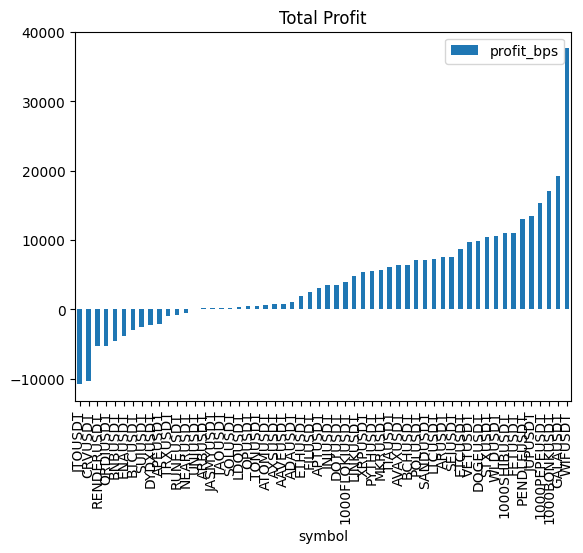

In [34]:
master_trade_df_sample.groupby("symbol").agg({"profit_bps": "sum"}).sort_values("profit_bps").plot.bar(title = "Total Profit")

<Axes: title={'center': 'Trade Count'}, xlabel='symbol'>

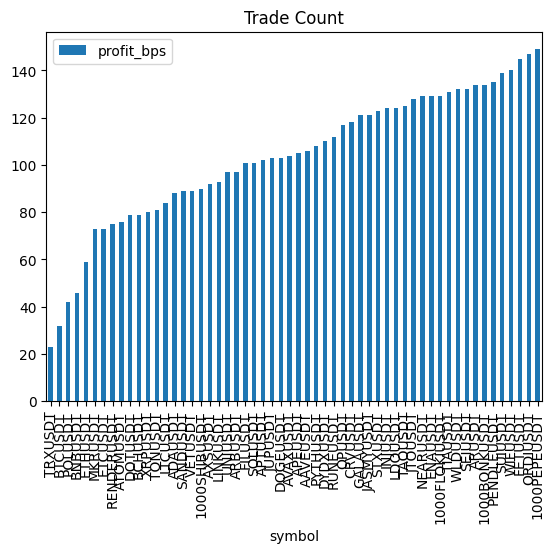

In [35]:
master_trade_df_sample.groupby("symbol").agg({"profit_bps": "count"}).sort_values("profit_bps").plot.bar( title = "Trade Count")

<Axes: title={'center': 'Average Profit'}, xlabel='symbol'>

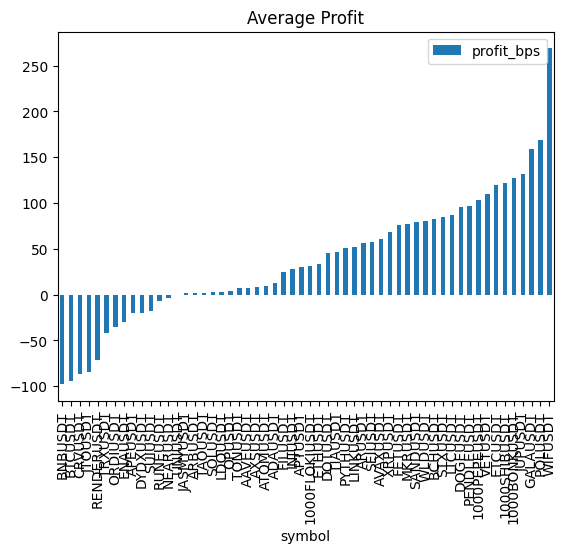

In [36]:
master_trade_df_sample.groupby("symbol").agg({"profit_bps": "mean"}).sort_values("profit_bps").plot.bar( title = "Average Profit")

In [37]:
trade_df = master_trade_df[master_trade_df['symbol']=='BTCUSDT']

In [38]:
periodwise_performance_analysis(trade_df, frequency = 'monthly')

In [39]:
# trade_df

In [40]:
volatility_analysis(trade_df)

10
                pnl_per_day_bps  std_bps  sharpe  avg_std  tval
all                       -74.0    194.3  -0.381      NaN   NaN
0.0-0.25_pctle            -32.6    198.1  -0.164   119.27  0.39
0.25-0.5_pctle           -102.3     86.7  -1.180   147.80 -1.74
0.5-0.75_pctle            -95.3    275.0  -0.346   183.72 -0.44
0.75-1.0_pctle            -84.1    199.0  -0.423   316.41 -0.45



5
                pnl_per_day_bps  std_bps  sharpe  avg_std  tval
all                       -63.8    220.4  -0.289      NaN   NaN
0.0-0.25_pctle            -33.8    113.5  -0.298    84.38  0.67
0.25-0.5_pctle            -90.1    220.1  -0.409   143.69 -0.52
0.5-0.75_pctle           -107.2    129.9  -0.825   208.88 -1.34
0.75-1.0_pctle             -3.3    344.1  -0.010   361.27  0.54





In [41]:
profit_mometum_analysis(trade_df)

['BTCUSDT']
3
                pnl_per_day_bps  std_bps  sharpe  avg_pnl_for_past  tval
all                       -51.4    228.6  -0.225               NaN   NaN
0.0-0.25_pctle            -12.1    167.2  -0.072           -167.67  0.93
0.25-0.5_pctle            -60.0    247.1  -0.243            -96.98 -0.04
0.5-0.75_pctle           -112.7    210.2  -0.536            -48.98 -0.92
0.75-1.0_pctle            -26.2    291.8  -0.090            108.42  0.38



1
                pnl_per_day_bps  std_bps  sharpe  avg_pnl_for_past  tval
all                       -47.8    226.2  -0.211               NaN   NaN
0.0-0.25_pctle            -21.2    221.8  -0.096           -302.29  0.56
0.25-0.5_pctle            -22.7    164.6  -0.138           -100.33  0.75
0.5-0.75_pctle            -92.6    136.0  -0.681            -29.87 -0.95
0.75-1.0_pctle            -55.7    350.8  -0.159            241.23  0.01



['BTCUSDT']
3
                pnl_per_day_bps  std_bps  sharpe  avg_pnl_for_past  tval
all            

<Axes: xlabel='exit_ts'>

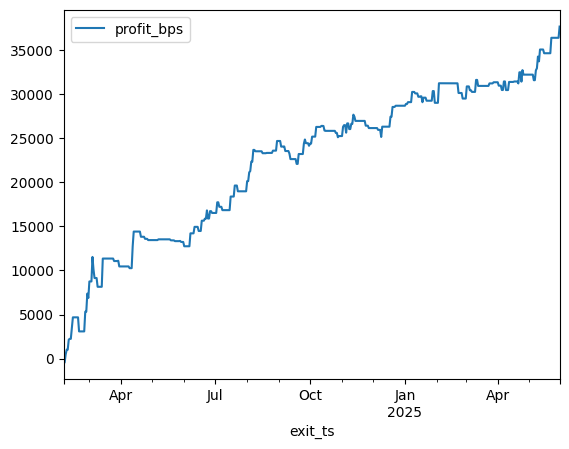

In [43]:
master_trade_df_sample[master_trade_df_sample['symbol']=='WIFUSDT'].set_index('exit_ts').resample("D").agg(
        {'profit_bps': 'sum'}).cumsum().plot()

In [44]:
symbol_interest  = SYMBOL_LIST

<Axes: xlabel='exit_ts'>

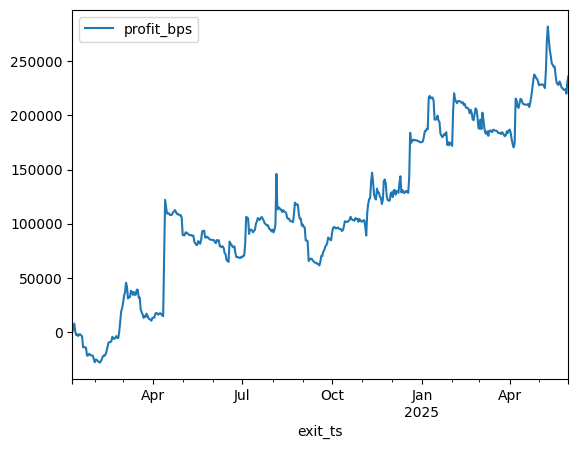

In [45]:
master_trade_df_sample[master_trade_df_sample['symbol'].isin(symbol_interest)].set_index('exit_ts').resample("D").agg(
        {'profit_bps': 'sum'}).cumsum().plot()

In [ ]:
master_trade_df_sample[master_trade_df_sample['symbol']=='XRPUSDT'].set_index('exit_ts').resample("D").agg(
        {'profit_bps': 'sum'}).cumsum().plot()

In [ ]:
import plotly.graph_objects as go

# Assuming you have a DataFrame named master_trade_df_sample and a list named symbol_interest

fig = go.Figure()

for symbol in symbol_interest:
    symbol_df = master_trade_df_sample[master_trade_df_sample['symbol'] == symbol]
    symbol_df_resampled = symbol_df.set_index('exit_ts').resample('D').agg({'profit_bps': 'sum'}).cumsum()

    fig.add_trace(go.Scatter(
        x=symbol_df_resampled.index,
        y=symbol_df_resampled['profit_bps'],
        mode='lines',
        name=symbol
    ))

fig.update_layout(
    title='Cumulative Profit by Symbol',
    xaxis_title='Date',
    yaxis_title='Cumulative Profit (bps)',
    height=800
)

fig.show()


In [46]:
master_trade_df_sample

,key,symbol,entry_ts,exit_ts,qty,profit_bps,hold_time,entry_price,exit_price,st_hl,...,vwap_price_diff_over_wind_threshold,vwap_price_diff_mult_sma_diff_sign,price_at_480,price_at_720,price_at_1080,st_bbands_vol_std_mult,st_roc_hl_mult,lt_roc_hl_mult,st_roc_std_mult,lt_roc_std_mult
0,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-09 08:27:00,2024-01-09 22:07:00,1,592.391517,820.0,0.013297,0.014098,0.163120,...,1.267553,0.050702,0.014098,0.014098,NaN,NaN,0.486159,0.642150,2.036582,3.629923
1,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-10 21:47:00,2024-01-10 22:34:00,1,1296.529431,47.0,0.015545,0.017576,0.168672,...,2.228079,0.089123,NaN,NaN,NaN,1.718884,0.342931,0.948351,1.632874,3.961481
2,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-11 13:19:00,2024-01-12 04:19:00,1,-815.656230,900.0,0.016831,0.015475,0.133563,...,1.839555,0.073582,0.015475,0.015475,NaN,0.458682,0.392801,1.348226,2.175940,5.729962
3,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-23 09:10:00,2024-01-24 00:10:00,-1,-564.185978,900.0,0.010141,0.010703,0.079282,...,-0.935344,0.037414,0.010703,0.010703,NaN,-0.378919,-0.710122,-0.787979,-3.402209,-3.333519
4,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",1000BONKUSDT,2024-01-25 20:03:00,2024-01-26 11:03:00,1,82.479497,900.0,0.011462,0.011568,0.109667,...,1.325248,0.053010,0.011568,0.011568,NaN,0.118278,0.577786,0.214184,3.456756,1.429127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5793,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-18 20:01:00,2025-05-18 23:57:00,-1,-652.451759,236.0,4.405000,4.688000,0.099886,...,-1.396897,0.055876,NaN,NaN,NaN,-0.246165,-0.560001,-0.583222,-3.119487,-2.445876
5794,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-22 16:02:00,2025-05-23 07:02:00,1,-65.630155,900.0,5.213000,5.184000,0.060234,...,0.933593,0.037344,5.184000,5.184000,NaN,0.196880,0.981543,0.949356,5.603145,4.931246
5795,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-28 00:55:00,2025-05-28 15:55:00,-1,226.433236,900.0,4.441000,4.336000,0.115289,...,-1.279341,0.051174,4.336000,4.336000,NaN,2.344005,-0.721625,-0.593716,-3.470458,-2.902501
5796,"all_sma_[720, 5040]_[720, 5040]_0.1_1_[30, 120...",RENDERUSDT,2025-05-30 01:05:00,2025-05-30 16:05:00,-1,159.242090,900.0,4.077000,4.008000,0.110621,...,-0.907532,0.036301,4.008000,4.008000,NaN,0.844003,-0.682606,-0.728440,-4.898246,-3.488646


In [47]:
check_alpha_decay(master_trade_df_sample)

Alpha Decay analysis, qty: -1
net_move -34.98102784440712
[0, 0.25] 6.359879643896027
[0, 0.5] 8.802352920313439
[0, 1] 12.260365311821133
[0, 2] -6.616549828087606
[0, 6] -17.204291300713752
[0, 12] -5.623761238407048
[0, 24] -38.39910763853173
[0, 48] -35.88923717161299
[0, 96] -35.03519795519577

Alpha Decay analysis, qty: 1


KeyboardInterrupt: 

In [142]:
config  = collections.OrderedDict([('symbol', 'BTCUSDT'),
             ('indicator', 'sma'),
             ('wind_lookback', [720, 5040]),
             ('unwind_lookback', [720, 5040]),
             ('wind_move_threshold', 0.1),
             ('bar_length', 1),
             ('volume_lookback', [30, 12000]),
             ('volume_std_mult', 2),
             ('30min_roc_threshold', -1),
             ('profit_take_threshold', [3, 3]),
             ('stoploss_threshold', [0.25, 0.25]),
             ('timeloss_param_dict', {900: [[0.03, 'pnl']]}),
             ('delay_added_mvmt_threshold_dict', {60: 0.75, 30: 0}),
             ('augment_unwind_lookback', None),
             ('roc_delay_period', 60),
             ('long_st_roc_threshold', 1.25),
             ('timeloss_type', 'once'),
             ('wind_move_threshold_type', 'percentile'),
             ('wind_move_threshold_lookback', 43200),
             ('min_wind_threshold', 0.04),
             ('btc_conditon_threshold', None),
             ('short_st_bbands_std_mult_threshold', -3.5)])

In [ ]:
bar_length = config['bar_length']
wind_lookback = config['wind_lookback']
wind_lookback = [int(wind_lookback[0]/bar_length), int(wind_lookback[1]/bar_length)]
unwind_lookback = config['unwind_lookback']
unwind_lookback = [int(unwind_lookback[0]/bar_length), int(unwind_lookback[1]/bar_length)]
augment_unwind_lookback = config['augment_unwind_lookback']
if augment_unwind_lookback != None:
    augment_unwind_lookback = [int(augment_unwind_lookback[0]/bar_length), int(augment_unwind_lookback[1]/bar_length)]
total_days = len(date_list)
symbol = config['symbol']
print (symbol)
symbol_df =  copy.deepcopy(DATA_DF[symbol])
symbol_df = symbol_df.rename('close')
symbol_df = symbol_df.to_frame()

eth_df =  DATA_DF['BTCUSDT']
eth_df = eth_df.rename('close')
eth_df = eth_df.to_frame()

symbol_df['high'] = symbol_df['close'].rolling(bar_length).max()
symbol_df['low'] = symbol_df['close'].rolling(bar_length).min()
symbol_df = symbol_df[::bar_length]
tradelist = []
symbol_volume_df = copy.deepcopy(VOLUME_DF[symbol])
symbol_volume_df = symbol_volume_df.rename('close')
symbol_volume_df = symbol_volume_df.to_frame()
sym_qty_volume_df = symbol_volume_df['close']
sym_qty_volume_df = sym_qty_volume_df.dropna()

symbol_volume_df['close'] =	symbol_volume_df['close'].multiply(symbol_df['close'])
symbol_df = symbol_df.dropna()
symbol_volume_df = symbol_volume_df.dropna()

eth_volume_df = copy.deepcopy(VOLUME_DF['BTCUSDT'])
eth_volume_df = eth_volume_df.rename('close')
eth_volume_df = eth_volume_df.to_frame()
eth_volume_df['close'] = eth_volume_df['close'].multiply(eth_df['close'])
eth_volume_df = eth_volume_df.dropna()
eth_volume_df = eth_volume_df.dropna()


volume_lookback = config['volume_lookback']
volume_std_thresh = config['volume_std_mult']
roc_delay_period =  config['roc_delay_period']
if volume_std_thresh == None:
    volume_std_thresh = -100
_30min_roc_threshold = config['30min_roc_threshold'] 
if _30min_roc_threshold == None: 
    _30min_roc_threshold = -100

long_st_roc_threshold = config['long_st_roc_threshold']
if long_st_roc_threshold == None:
    long_st_roc_threshold = -100
timeloss_dict = config['timeloss_param_dict']
timeloss_checkpoints_df_dict = {}
if timeloss_dict!= None:
    for _key in timeloss_dict.keys():
        timeloss_checkpoints_df_dict[_key] = symbol_df["close"].rolling(_key).std()/symbol_df['close']
min_wind_threshold = config['min_wind_threshold']
if config['indicator'] == 'sma':
    st_ma = getattr(TA, 'SMA')(symbol_df, period = wind_lookback[0])
    mt_ma = getattr(TA, 'SMA')(symbol_df, period = 2880)
    lt_ma = getattr(TA, 'SMA')(symbol_df, period = wind_lookback[1])
    unwind_st_ma = getattr(TA, 'SMA')(symbol_df, period = unwind_lookback[0])
    unwind_lt_ma = getattr(TA, 'SMA')(symbol_df, period = unwind_lookback[1])

    eth_st_ma = getattr(TA, 'SMA')(eth_df, period = wind_lookback[0])
    eth_lt_ma = getattr(TA, 'SMA')(eth_df, period = wind_lookback[1])
    vol_mult_price = symbol_volume_df['close']#*symbol_df['close']
    vol_mult_price = vol_mult_price.rename('close').to_frame()
    st_vwap_ma = getattr(TA, 'SMA')(vol_mult_price,  period = wind_lookback[0]) / sym_qty_volume_df.rolling(wind_lookback[0]).mean()
    lt_vwap_ma = getattr(TA, 'SMA')(vol_mult_price,  period = wind_lookback[1]) / sym_qty_volume_df.rolling(wind_lookback[1]).mean()
    
    #unwind_st_ma = st_vwap_ma
    #unwind_lt_ma = lt_vwap_ma
    
    if augment_unwind_lookback != None:
        aug_st_ma = getattr(TA, 'SMA')(symbol_df, period = augment_unwind_lookback[0])
        aug_lt_ma = getattr(TA, 'SMA')(symbol_df, period = augment_unwind_lookback[1])

    st_hl = getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = wind_lookback[0]) / symbol_df['close']
    lt_hl = getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = wind_lookback[1]) / symbol_df['close']
    st_std = symbol_df["close"].rolling(wind_lookback[0]).std()/symbol_df['close']
    lt_std = symbol_df["close"].rolling(wind_lookback[1]).std()/symbol_df['close']
    st_rsi = getattr(TA, 'RSI')(symbol_df, period = wind_lookback[0])
    lt_rsi = getattr(TA, 'RSI')(symbol_df, period = wind_lookback[1])
    st_bbands_std_mult = getattr(TA, 'BBANDSSTDDIST')(symbol_df, period = wind_lookback[0])
    lt_bbands_std_mult = getattr(TA, 'BBANDSSTDDIST')(symbol_df, period = wind_lookback[1])
    st_roc = getattr(TA, 'ROC')(symbol_df, period = wind_lookback[0])
    lt_roc = getattr(TA, 'ROC')(symbol_df, period = wind_lookback[1])

    last_5min_roc = getattr(TA, 'ROC')(symbol_df, period = int(5/bar_length))
    last_15min_roc = getattr(TA, 'ROC')(symbol_df, period = int(15/bar_length))
    last_30min_roc = getattr(TA, 'ROC')(symbol_df, period = int(30/bar_length))
    last_60min_roc = getattr(TA, 'ROC')(symbol_df, period = int(60/bar_length))

    lt_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[1]/bar_length))
    st_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[0]/bar_length))
    very_lt_stoch = getattr(TA, 'STOCHCLOSE')(symbol_df, period = int(wind_lookback[1]*2/bar_length))

    ma_volume = getattr(TA, 'SMA')(symbol_volume_df, period = volume_lookback[0])
    vol_mult_price = symbol_volume_df['close']*symbol_df['close']
    st_vwap_price = vol_mult_price.rolling(wind_lookback[0]).sum()/symbol_volume_df['close'].rolling(wind_lookback[0]).sum()
    lt_vwap_price = vol_mult_price.rolling(wind_lookback[1]).sum()/symbol_volume_df['close'].rolling(wind_lookback[1]).sum()
    
    ma_volume = ma_volume.rename('close')
    ma_volume = ma_volume.to_frame()
    bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(ma_volume, period = volume_lookback[1])

    eth_ma_volume = getattr(TA, 'SMA')(eth_volume_df, period = volume_lookback[0])
    eth_ma_volume = eth_ma_volume.rename('close')
    eth_ma_volume = eth_ma_volume.to_frame()
    eth_bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(eth_ma_volume, period = volume_lookback[1])

    symbol_df['date'] = symbol_df.index
    symbol_df['date'] = symbol_df['date'].dt.date
    wind_move_threshold = config['wind_move_threshold']
    wind_move_threshold_type = config['wind_move_threshold_type']
    
    very_lt_range =  getattr(TA, 'PEAKMINUSTROUGHCLOSE')(symbol_df, period = 1440*31) / symbol_df['close']  
    very_lt_roc =  getattr(TA, 'ROC')(symbol_df, period = 1440*31) 
    abs_very_lt_roc = abs(very_lt_roc)
    
    st_ma_volume = getattr(TA, 'SMA')(symbol_volume_df, period = wind_lookback[0])
    st_ma_volume = st_ma_volume.rename('close')
    st_ma_volume = st_ma_volume.to_frame()
    st_bbands_vol_std_mult = getattr(TA, 'BBANDSSTDDIST')(st_ma_volume, period = volume_lookback[1])
    
    if wind_move_threshold_type == 'percentile':
        if min_wind_threshold == None:
            min_wind_threshold = 0
        temp = abs(symbol_df['close']-st_ma)/symbol_df['close']
        lookback_threhsold  = config['wind_move_threshold_lookback']
        temp = temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold)#(abs(temp.rolling(lookback_threhsold).quantile(wind_move_threshold)) + temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold))/2
        temp.iloc[:lookback_threhsold] = max(0.04, min_wind_threshold)
        wind_move_threshold_df = temp
        wind_move_threshold_df = wind_move_threshold_df.apply(lambda x: max(x, min_wind_threshold))
        #wind_move_threshold_df = wind_move_threshold_df.apply(lambda x: min(x, 0.06))

        #print (symbol, wind_move_threshold)
        eth_temp = abs(eth_df['close']-eth_st_ma)/eth_df['close']
        eth_temp = eth_temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold)#(abs(temp.rolling(lookback_threhsold).quantile(wind_move_threshold)) + temp.rolling(lookback_threhsold).quantile(1-wind_move_threshold))/2
        eth_temp.iloc[:lookback_threhsold] = max(0.04, min_wind_threshold)
        eth_wind_move_threshold_df = eth_temp
        eth_wind_move_threshold_df = eth_wind_move_threshold_df.apply(lambda x: max(x, min_wind_threshold))
        eth_sma_diff = (eth_df['close']-eth_st_ma)/eth_df['close']
        eth_close_sma_diff_pct =  eth_sma_diff / eth_wind_move_threshold_df
        btc_conditon_threshold = config['btc_conditon_threshold']
        if btc_conditon_threshold==None:
            btc_conditon_threshold = 100
        if config['short_st_bbands_std_mult_threshold'] == None:
            st_bbands_std_mult_threshold = -1000
        else:
            st_bbands_std_mult_threshold = config['short_st_bbands_std_mult_threshold']
        if long_st_roc_threshold >0.2:
            long_st_roc_threshold = long_st_roc_threshold * wind_move_threshold_df
        wind_df = symbol_df[ (symbol_df['date'].isin(date_list)) &  (bbands_vol_std_mult > volume_std_thresh) & \
                            (((LONG_ALLOWED) & (st_roc > long_st_roc_threshold) & (unwind_st_ma>unwind_lt_ma)  & (st_ma > lt_ma ) & (symbol_df['close'] > st_ma * (1 + wind_move_threshold_df))) | \
                            ((SHORT_ALLOWED)  & (st_bbands_std_mult > st_bbands_std_mult_threshold) & (unwind_st_ma<unwind_lt_ma)  & (st_ma < lt_ma) & (eth_close_sma_diff_pct < btc_conditon_threshold) & (symbol_df['close'] < st_ma * (1 - wind_move_threshold_df))))]						
    else:
        wind_df = symbol_df[(symbol_df['date'].isin(date_list)) &  (bbands_vol_std_mult > volume_std_thresh) & \
                            (((LONG_ALLOWED) & (unwind_st_ma >  unwind_lt_ma) & (st_ma > lt_ma ) & (symbol_df['close'] > st_ma * (1 + wind_move_threshold))) | \
                            ((SHORT_ALLOWED) & (st_ma < lt_ma) & (unwind_st_ma <  unwind_lt_ma)  & (symbol_df['close'] < st_ma * (1 - wind_move_threshold))))]						

    unwind_df =  symbol_df[ (LONG_ALLOWED & ((st_ma < lt_ma) | (symbol_df['close'] < lt_ma)| (unwind_st_ma <  unwind_lt_ma))) \
                        | ((SHORT_ALLOWED) & ((st_ma > lt_ma)| (symbol_df['close'] > lt_ma) | (unwind_st_ma >  unwind_lt_ma)))]
    unwind_df['short_unwind'] = (unwind_st_ma > unwind_lt_ma) | (symbol_df['close'] > lt_ma) | (st_ma > lt_ma)
    unwind_df['long_unwind'] = (unwind_st_ma < unwind_lt_ma)| (st_ma < lt_ma)
    if augment_unwind_lookback != None:
        unwind_df['short_unwind'] = (unwind_df['short_unwind']) | (aug_st_ma > aug_lt_ma) 
        unwind_df['long_unwind'] = (unwind_df['long_unwind']) | (aug_st_ma < aug_lt_ma) 
    eth_last_15min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(15/bar_length))
    eth_last_30min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(30/bar_length))
    eth_last_60min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(60/bar_length))
    eth_last_120min_roc_df = getattr(TA, 'ROC')(eth_df, period = int(120/bar_length))


In [ ]:
len(unwind_df)

In [145]:
symbol_df['wind_move_threshold']=st_ma * (1 + wind_move_threshold_df)

In [146]:
symbol_df['st_ma']=st_ma

In [147]:
pd.options.plotting.backend = 'matplotlib'


In [ ]:
symbol_df[['close','wind_move_threshold','st_ma']].plot(figsize=(15,15))

In [166]:
wind_df = symbol_df[ (symbol_df['date'].isin(date_list)) &  (bbands_vol_std_mult > volume_std_thresh) & \
                        (((LONG_ALLOWED) & (st_roc > long_st_roc_threshold) & (unwind_st_ma>unwind_lt_ma)  & (st_ma > lt_ma ) & (symbol_df['close'] > st_ma * (1 + wind_move_threshold_df))) | \
                        ((SHORT_ALLOWED)  & (st_bbands_std_mult > st_bbands_std_mult_threshold) & (unwind_st_ma<unwind_lt_ma)  & (st_ma < lt_ma) & (eth_close_sma_diff_pct < btc_conditon_threshold) & (symbol_df['close'] < st_ma * (1 - wind_move_threshold_df))))]						


In [175]:
wind_df = symbol_df[ (symbol_df['date'].isin(date_list)) &  (bbands_vol_std_mult > volume_std_thresh) & \
                        (((LONG_ALLOWED) & (st_roc > long_st_roc_threshold) & (unwind_st_ma>unwind_lt_ma)  & (st_ma > lt_ma ) & (symbol_df['close'] > st_ma * (1 + wind_move_threshold_df))) )]


In [ ]:
len(wind_df)

In [ ]:
SHORT_ALLOWED

In [ ]:
wind_move_threshold_df.plot()

In [ ]:
wind_df